In [ ]:
import os
import zipfile
import random
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset

from collections import defaultdict
from contextlib import contextmanager

import time

from PIL import Image
from zipfile import ZipFile
import csv

from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Load

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def custom_dataloader(data_dir, transform, batch_size=64, num_workers=1):

  '''
  input:
    data_dir: file path of input data. raw_dataset are created from that file
    batch_size
    num_workers
  output:
    train_loader, val_loader, test_loader
  -----
  data is transformed by data_transform. train:val:test = 0.8:0.1:0.1 with each classes equally splitted
    '''

  raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
  print(raw_dataset)
  np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
  indices = np.arange(len(raw_dataset))
  np.random.shuffle(indices)
  train_split = int(len(indices) * 0.8)
  testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
  # split into training and validation indices
  relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                            num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(test_indices)
  test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=test_sampler)
  print(f'data loading completed')
  return train_loader, val_loader, test_loader

In [ ]:
def count_classes(loader):
    class_counts = defaultdict(int)
    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1
    return class_counts

def data_class_analysis(train_loader, val_loader, test_loader):
  '''
  input: train_loader, val_loader, test_loader
  output: class_df-dataframe that contains number of data in each class for each train, val, test loader.
  '''
  # Count classes for each loader
  train_class_counts = count_classes(train_loader)
  val_class_counts = count_classes(val_loader)
  test_class_counts = count_classes(test_loader)

  # Create a DataFrame
  class_data = {'Train': train_class_counts, 'Validation': val_class_counts, 'Test': test_class_counts}
  class_df = pd.DataFrame(class_data).fillna(0).sort_index()  # Fill NaN values with 0

  # Print or display the DataFrame
  print(class_df)
  return class_df

In [ ]:
zip_file_path = '/content/drive/MyDrive/UofT/MIE1517/project/wikiART224.zip'
unzipped_dir = '/content/extracted_data'
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzipped_dir)

# List the files in the extracted folder
extracted_files = os.listdir(unzipped_dir)
print("Extracted files:", extracted_files)

Extracted files: ['wikiART224']


In [ ]:
unzipped_dir = '/content/extracted_data'
rawdata_dir = os.path.join(unzipped_dir, 'wikiART224')


train_loader, val_loader, test_loader = custom_dataloader(rawdata_dir, transform)
#class_df = data_class_analysis(train_loader, val_loader, test_loader)

Dataset ImageFolder
    Number of datapoints: 81442
    Root location: /content/extracted_data/wikiART224
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
data loading completed


### Subset Classes

In [ ]:
def subset_dataloader(data_dir, transform, used_classes, batch_size=64, num_workers=1):

  '''
  input:
    data_dir: file path of input data. raw_dataset are created from that file
    batch_size
    num_workers
  output:
    train_loader, val_loader, test_loader
  -----
  data is transformed by data_transform. train:val:test = 0.8:0.1:0.1 with each classes equally splitted
    '''


  raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
  idx = [i for i in range(len(raw_dataset)) if raw_dataset.imgs[i][1] in [raw_dataset.class_to_idx[c] for c in used_classes]]
  subset = Subset(raw_dataset, idx)

  #filtered_class_to_idx = {cls: idx for idx, cls in enumerate(used_classes)}
  #reindexed_subset = [(img, filtered_class_to_idx[raw_dataset.classes[label]]) for img, label in subset]
  #print(reindexed_subset)

  print(len(subset))
  np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
  indices = np.arange(len(subset))
  np.random.shuffle(indices)
  train_split = int(len(indices) * 0.8)
  testval_split = train_split + int(len(indices) * (1 - 0.8)/2)
  # split into training and validation indices
  relevant_train_indices, relevant_val_indices,test_indices = indices[:train_split], indices[train_split:testval_split] ,indices[testval_split:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                             num_workers=num_workers, sampler=train_sampler)
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                            num_workers=num_workers, sampler=val_sampler)
  test_sampler = SubsetRandomSampler(test_indices)
  test_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=test_sampler)
  print(f'data loading completed')
  return train_loader, val_loader, test_loader

In [ ]:
unzipped_dir = '/content/extracted_data'
data_dir = os.path.join(unzipped_dir, 'wikiART224')

used_class = ['Abstract_Expressionism', 'Art_Nouveau_Modern', 'Baroque',  'Cubism', 'Expressionism', 'Impressionism', 'Naive_Art_Primitivism', 'Northern_Renaissance', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism']
train_loader_subset, val_loader_subset, test_loader_subset = subset_dataloader(data_dir, transform, used_class)
#class_df = data_class_analysis(train_loader_subset, val_loader_subset, test_loader_subset)

69161
data loading completed


### wikiART9

In [ ]:
transform_crop = transforms.Compose([
    transforms.CenterCrop((75, 75)),# crop
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader_crop, val_loader_crop, test_loader_crop = subset_dataloader(data_dir, transform_crop, used_class)

69161
data loading completed


# Define model

In [ ]:
class StyleResNet18(nn.Module):
  def __init__(self, hidden_dim=128):
    super(StyleResNet18, self).__init__()

    resnet = models.resnet18(pretrained=True)
    self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

    self.fc1 = nn.Linear(512, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 27)
    self.dropout = nn.Dropout(p=0.2)
    self.flatten = nn.Flatten()
    self.ReLU = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.resnet_features(x)
    x = self.flatten(x)
    x = self.ReLU(self.fc1(x))
    x = self.dropout(x)
    x= self.fc2(x)

    return x

In [ ]:
class StyleResNet18_FC(nn.Module):
  def __init__(self, hidden_dim1=128, hidden_dim2=64):
    super(StyleResNet18_FC, self).__init__()

    resnet = models.resnet18(pretrained=True)
    self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

    self.fc1 = nn.Linear(512, hidden_dim1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.fc3 = nn.Linear(hidden_dim2, 27)
    self.dropout = nn.Dropout(p=0.2)
    self.flatten = nn.Flatten()
    self.ReLU = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.resnet_features(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.ReLU(self.fc1(x))
    x = self.dropout(x)
    x = self.ReLU(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
class StyleResNet101(nn.Module):
  def __init__(self, hidden_dim1=128, hidden_dim2=64):
    super(StyleResNet101, self).__init__()

    resnet = models.resnet18(pretrained=True)
    self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

    self.fc1 = nn.Linear(512, hidden_dim1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.fc3 = nn.Linear(hidden_dim2, 27)
    self.dropout = nn.Dropout(p=0.2)
    self.flatten = nn.Flatten()
    self.ReLU = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.resnet_features(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.ReLU(self.fc1(x))
    x = self.dropout(x)
    x = self.ReLU(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
class StyleResNet101_FC4(nn.Module):
  def __init__(self, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64):
    super(StyleResNet101_FC4, self).__init__()

    resnet = models.resnet18(pretrained=True)
    self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

    self.fc1 = nn.Linear(512, hidden_dim1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
    self.fc4 = nn.Linear(hidden_dim3, 27)
    self.dropout = nn.Dropout(p=0.4)
    self.flatten = nn.Flatten()
    self.ReLU = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.resnet_features(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.ReLU(self.fc1(x))
    x = self.dropout(x)
    x = self.ReLU(self.fc2(x))
    x = self.dropout(x)
    x = self.ReLU(self.fc3(x))
    x = self.dropout(x)
    x = self.fc4(x)

    return x

In [ ]:
class StyleResNet50(nn.Module):
  def __init__(self, hidden_dim1=1024, hidden_dim2=256):
    super(StyleResNet50, self).__init__()

    resnet = models.resnet50(pretrained=True)
    self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])

    self.fc1 = nn.Linear(2048, hidden_dim1)
    self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.fc3 = nn.Linear(hidden_dim2, 27)
    self.dropout = nn.Dropout(p=0.4)
    self.flatten = nn.Flatten()
    self.ReLU = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.resnet_features(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.ReLU(self.fc1(x))
    x = self.dropout(x)
    x = self.ReLU(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return x

# Training

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [ ]:
def train_model(model, model_name, train_loader, valid_loader, device, num_epochs=4, lr=0.0001, wd=0):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    model.to(device)
    model.train()

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(num_epochs):

        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        tqdm_bar = tqdm(train_loader)

        for batch_idx, (inputs, labels) in enumerate(tqdm_bar):
            with torch.set_grad_enabled(True):
              inputs, labels = inputs.to(device), labels.to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, labels)

              loss.backward()
              optimizer.step()

              running_loss += loss.item()
              pred = outputs.max(1, keepdim=True)[1]
              running_pred += pred.eq(labels.view_as(pred)).sum().item()
              running_total += pred.shape[0]

        train_loss, train_acc = evaluate_model(model, train_loader, device)
        valid_loss, valid_acc = evaluate_model(model, valid_loader, device)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')
        running_loss = 0.0
        running_pred = 0.0
        running_total = 0.0
        model.train()

        joblib.dump(model, f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/{model_name}_epoch{epoch+1}.joblib')

        results = pd.DataFrame({'train loss': train_losses, 'valid loss': valid_losses, 'train accuracy': train_accuracies, 'valid accuracy': valid_accuracies})
        results.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/{model_name}_results.csv')
    end_time = time.time()
    elapsed_time = end_time - start_time
    plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time)


    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

In [ ]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, elapsed_time):
    print(f'elapsed time: {elapsed_time}')
    epochs = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('iteration')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('iteration')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():

        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)
          #pred = (output > 0.0).squeeze().long()
          #total_correct += (pred == labels).sum().item()
          pred = output.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()
          total_samples += data.size(0)

    accuracy = total_correct / total_samples
    average_loss = total_loss / total_samples

    return average_loss, accuracy

##sanity check

In [ ]:
unzipped_dir = '/content/extracted_data'
data_dir = os.path.join(unzipped_dir, 'wikiART224')

raw_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
num_workers = 1
batch_size = 32
train_sample = 2000
val_sample = 200
test_sample = 20

train_indices = np.random.choice(len(raw_dataset), train_sample, replace=False)
val_indices = np.random.choice(len(raw_dataset), val_sample, replace=False)
test_indices = np.random.choice(len(raw_dataset), test_sample, replace=False)

sanity_train_sampler = SubsetRandomSampler(train_indices)
sanity_val_sampler = SubsetRandomSampler(val_indices)
sanity_test_sampler = SubsetRandomSampler(test_indices)

sanity_train_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                           num_workers=num_workers, sampler=sanity_train_sampler)
sanity_val_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                         num_workers=num_workers, sampler=sanity_val_sampler)
sanity_test_loader = torch.utils.data.DataLoader(raw_dataset, batch_size=batch_size,
                                          num_workers=num_workers, sampler=sanity_test_sampler)

#sanity_class_df = data_class_analysis(sanity_train_loader, sanity_val_loader, sanity_test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 63/63 [00:08<00:00,  7.81it/s]


Epoch [1/3], Step [63/63], Training Loss: 2.1371, Training Accuracy: 0.3835, Validation Loss: 2.4041, Validation Accuracy: 0.3300


100%|██████████| 63/63 [00:07<00:00,  8.38it/s]


Epoch [2/3], Step [63/63], Training Loss: 1.4986, Training Accuracy: 0.5755, Validation Loss: 2.2044, Validation Accuracy: 0.3300


100%|██████████| 63/63 [00:09<00:00,  6.51it/s]


Epoch [3/3], Step [63/63], Training Loss: 0.9275, Training Accuracy: 0.7855, Validation Loss: 2.0940, Validation Accuracy: 0.4150
elapsed time: 46.600614070892334


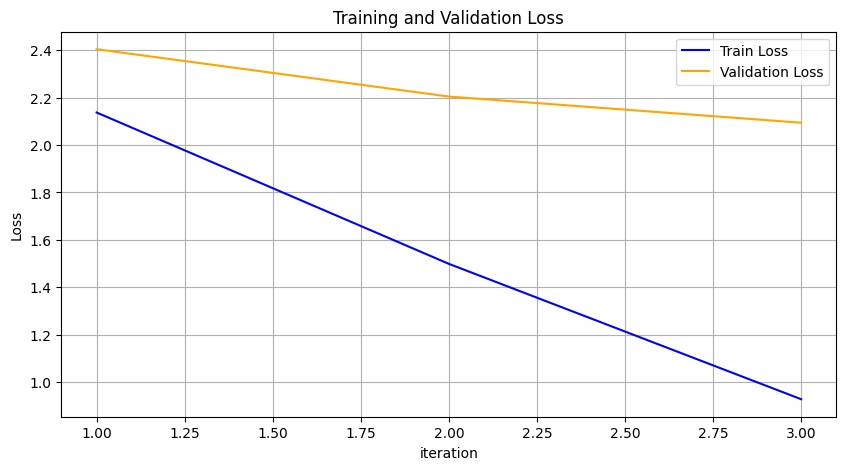

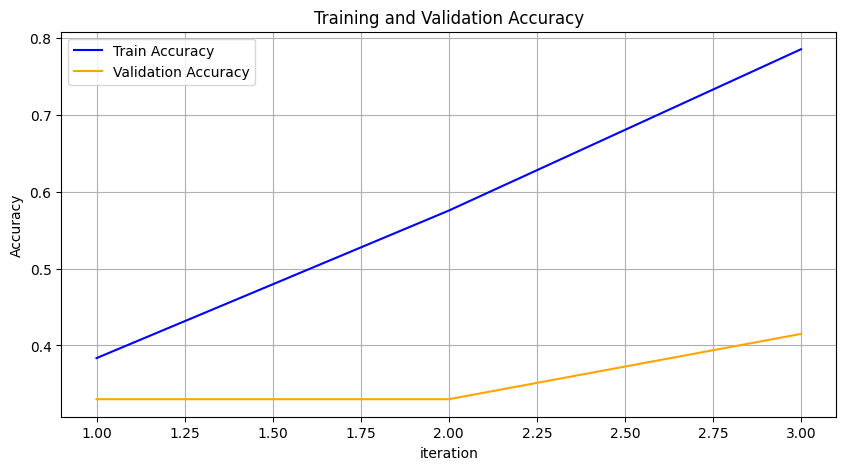

In [ ]:
model = StyleResNet18()
sanity_model, train_losses_san, valid_losses_san, train_accuracies_san, valid_accuracies_san = train_model(model, 'sanity', sanity_train_loader, sanity_val_loader, device, num_epochs = 3)

##TRAIN WIkiART224

 50%|████▉     | 509/1019 [04:44<7:18:47, 51.62s/it]

Epoch [1/5], Step [509/1019], Training Loss: 1.5176, Training Accuracy: 0.5108, Validation Loss: 1.6351, Validation Accuracy: 0.4778


100%|██████████| 1019/1019 [09:16<00:00,  1.83it/s]

Epoch [1/5], Step [1018/1019], Training Loss: 1.4066, Training Accuracy: 0.5398, Validation Loss: 1.5894, Validation Accuracy: 0.4773



 50%|████▉     | 509/1019 [04:39<7:19:37, 51.72s/it]

Epoch [2/5], Step [509/1019], Training Loss: 1.1697, Training Accuracy: 0.6159, Validation Loss: 1.4892, Validation Accuracy: 0.5134


100%|██████████| 1019/1019 [09:10<00:00,  1.85it/s]

Epoch [2/5], Step [1018/1019], Training Loss: 0.9693, Training Accuracy: 0.6838, Validation Loss: 1.3925, Validation Accuracy: 0.5457



 50%|████▉     | 509/1019 [04:30<6:56:20, 48.98s/it]

Epoch [3/5], Step [509/1019], Training Loss: 0.7748, Training Accuracy: 0.7520, Validation Loss: 1.4237, Validation Accuracy: 0.5414


100%|██████████| 1019/1019 [09:03<00:00,  1.87it/s]

Epoch [3/5], Step [1018/1019], Training Loss: 0.6625, Training Accuracy: 0.7885, Validation Loss: 1.3986, Validation Accuracy: 0.5518



 50%|████▉     | 509/1019 [04:31<6:57:27, 49.11s/it]

Epoch [4/5], Step [509/1019], Training Loss: 0.4944, Training Accuracy: 0.8427, Validation Loss: 1.5056, Validation Accuracy: 0.5419


100%|██████████| 1019/1019 [09:02<00:00,  1.88it/s]

Epoch [4/5], Step [1018/1019], Training Loss: 0.3861, Training Accuracy: 0.8817, Validation Loss: 1.4855, Validation Accuracy: 0.5556



 50%|█████     | 510/1019 [04:30<4:50:26, 34.24s/it]

Epoch [5/5], Step [509/1019], Training Loss: 0.3148, Training Accuracy: 0.9030, Validation Loss: 1.6933, Validation Accuracy: 0.5427


100%|██████████| 1019/1019 [08:59<00:00,  1.89it/s]

Epoch [5/5], Step [1018/1019], Training Loss: 0.2606, Training Accuracy: 0.9240, Validation Loss: 1.7245, Validation Accuracy: 0.5295


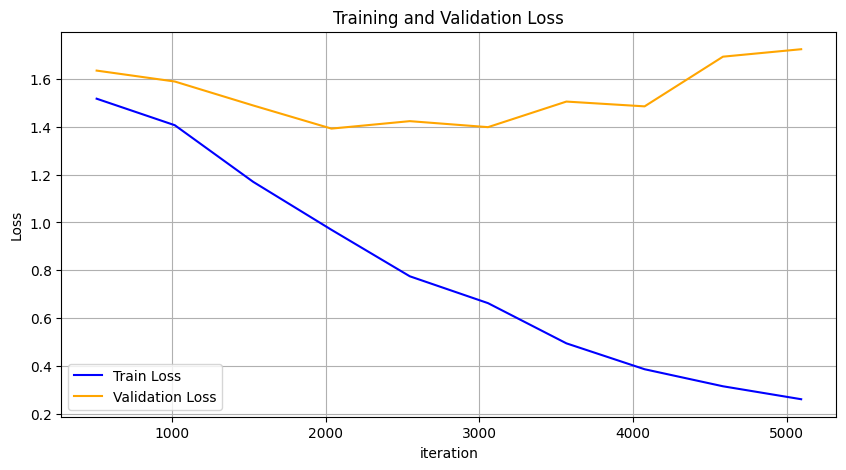

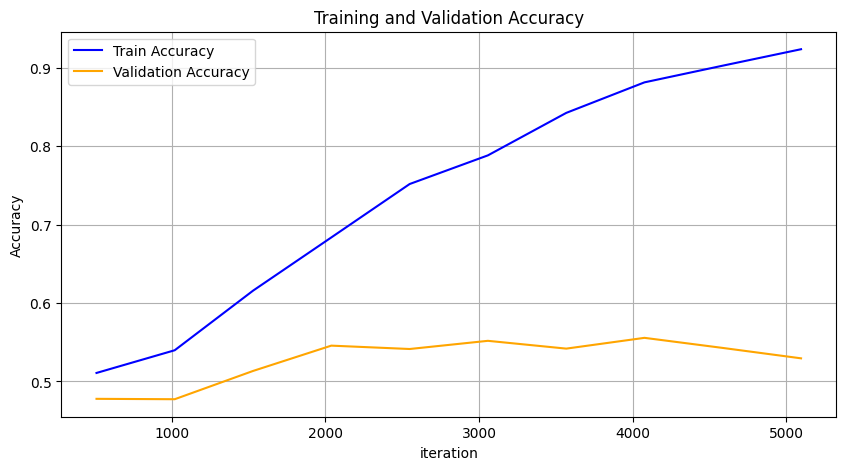

In [ ]:
model = StyleResNet18()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'model', train_loader, val_loader, device, num_epochs = 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 99%|█████████▉| 1009/1019 [06:35<08:40, 52.00s/it]

Epoch [1/5], Step [1009/1019], Training Loss: 1.4003, Training Accuracy: 0.5425, Validation Loss: 1.5671, Validation Accuracy: 0.4907


 99%|█████████▉| 1009/1019 [06:59<08:44, 52.43s/it]

Epoch [2/5], Step [1009/1019], Training Loss: 1.0668, Training Accuracy: 0.6533, Validation Loss: 1.4221, Validation Accuracy: 0.5405


 99%|█████████▉| 1009/1019 [06:38<09:03, 54.39s/it]

Epoch [3/5], Step [1009/1019], Training Loss: 0.8205, Training Accuracy: 0.7293, Validation Loss: 1.4966, Validation Accuracy: 0.5278


 99%|█████████▉| 1009/1019 [06:25<08:24, 50.47s/it]

Epoch [4/5], Step [1009/1019], Training Loss: 0.4934, Training Accuracy: 0.8451, Validation Loss: 1.4909, Validation Accuracy: 0.5523


 99%|█████████▉| 1009/1019 [06:28<08:30, 51.02s/it]

Epoch [5/5], Step [1009/1019], Training Loss: 0.3681, Training Accuracy: 0.8782, Validation Loss: 1.8065, Validation Accuracy: 0.5231


100%|██████████| 1019/1019 [06:30<00:00,  2.61it/s]


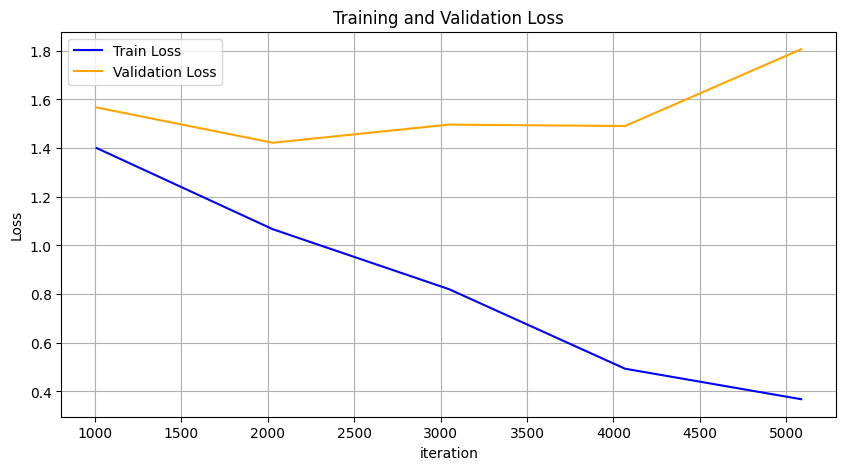

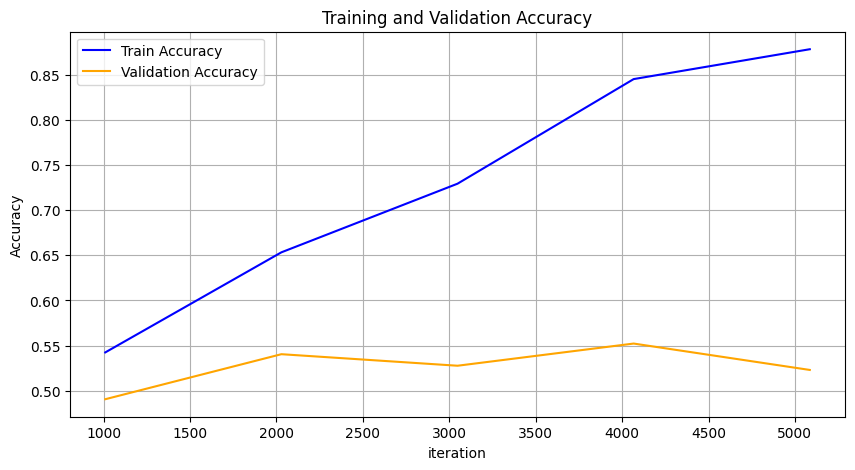

In [ ]:
#resnet18 with 3 fc layers
model = StyleResNet18_FC()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'fc3', train_loader, val_loader, device, num_epochs = 5)

100%|██████████| 1019/1019 [06:35<00:00,  2.57it/s]

Epoch [1/5], Step [1019/1019], Training Loss: 1.4024, Training Accuracy: 0.5405, Validation Loss: 1.5626, Validation Accuracy: 0.4896



100%|██████████| 1019/1019 [06:35<00:00,  2.58it/s]

Epoch [2/5], Step [1019/1019], Training Loss: 1.0791, Training Accuracy: 0.6476, Validation Loss: 1.4610, Validation Accuracy: 0.5262



100%|██████████| 1019/1019 [06:32<00:00,  2.60it/s]

Epoch [3/5], Step [1019/1019], Training Loss: 0.7979, Training Accuracy: 0.7343, Validation Loss: 1.4789, Validation Accuracy: 0.5381



100%|██████████| 1019/1019 [06:33<00:00,  2.59it/s]

Epoch [4/5], Step [1019/1019], Training Loss: 0.5317, Training Accuracy: 0.8275, Validation Loss: 1.5960, Validation Accuracy: 0.5354



100%|██████████| 1019/1019 [06:46<00:00,  2.51it/s]

Epoch [5/5], Step [1019/1019], Training Loss: 0.3927, Training Accuracy: 0.8716, Validation Loss: 1.8870, Validation Accuracy: 0.5075


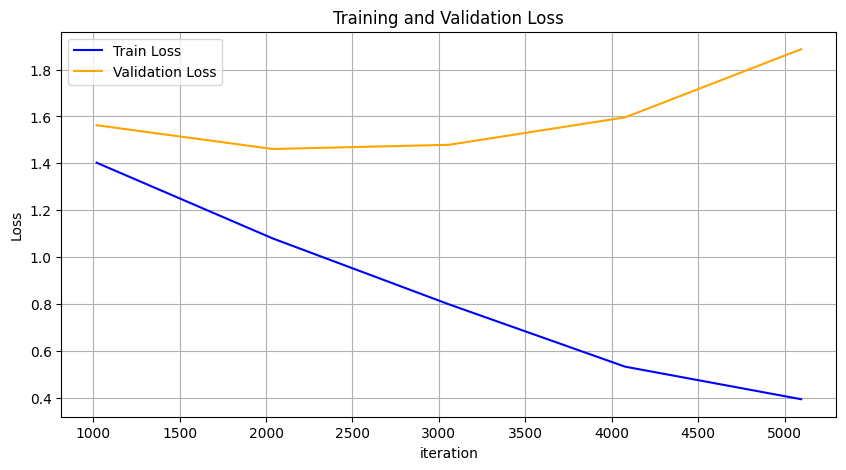

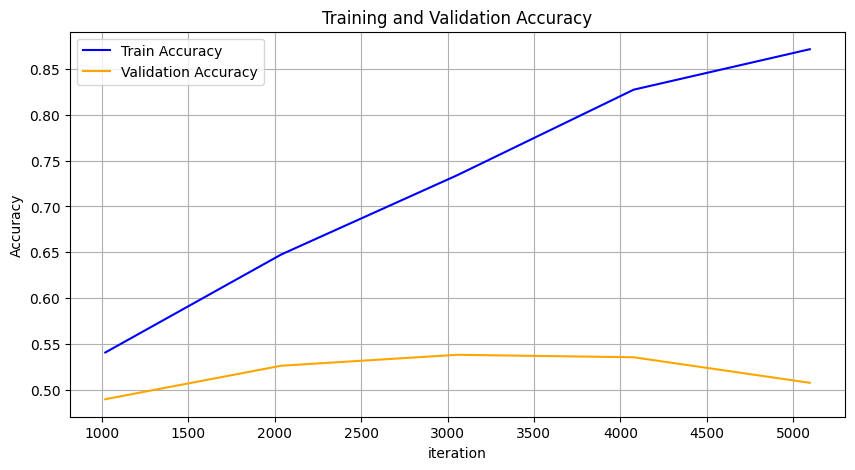

In [ ]:
# try resnet101
model = StyleResNet101()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet101', train_loader, val_loader, device, num_epochs = 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 255/255 [06:24<00:00,  1.51s/it]

Epoch [1/5], Step [255/255], Training Loss: 1.5739, Training Accuracy: 0.5046, Validation Loss: 1.6868, Validation Accuracy: 0.4632



100%|██████████| 255/255 [06:20<00:00,  1.49s/it]

Epoch [2/5], Step [255/255], Training Loss: 1.1584, Training Accuracy: 0.6250, Validation Loss: 1.4662, Validation Accuracy: 0.5302



100%|██████████| 255/255 [06:22<00:00,  1.50s/it]

Epoch [3/5], Step [255/255], Training Loss: 0.8517, Training Accuracy: 0.7261, Validation Loss: 1.4450, Validation Accuracy: 0.5376



100%|██████████| 255/255 [06:50<00:00,  1.61s/it]

Epoch [4/5], Step [255/255], Training Loss: 0.6947, Training Accuracy: 0.7764, Validation Loss: 1.6398, Validation Accuracy: 0.5093



100%|██████████| 255/255 [06:21<00:00,  1.50s/it]

Epoch [5/5], Step [255/255], Training Loss: 0.4421, Training Accuracy: 0.8607, Validation Loss: 1.8057, Validation Accuracy: 0.5052


elapsed time: 381.4763991832733


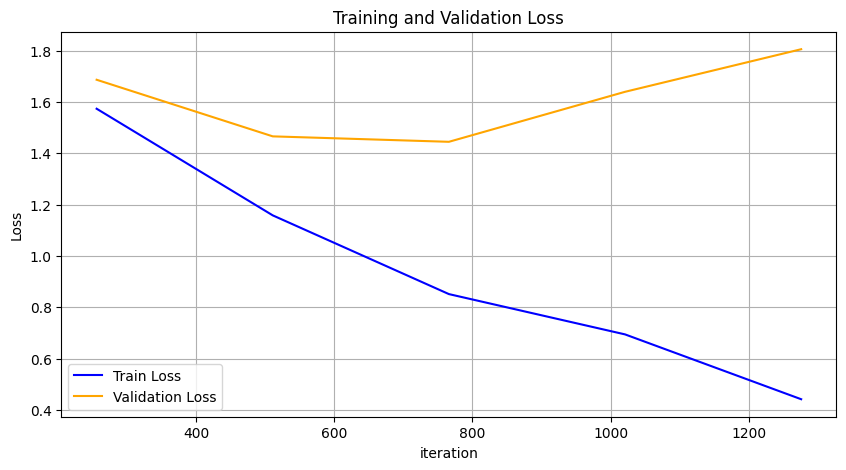

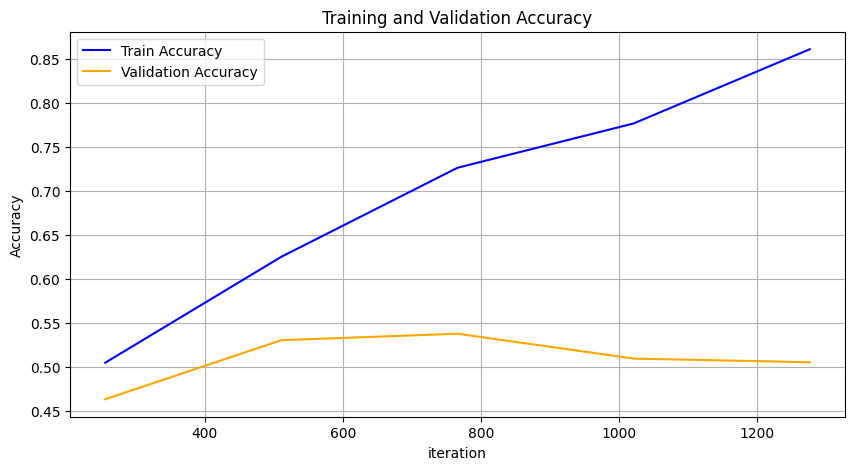

In [ ]:
# batch_size 256(larger) with resnet101
unzipped_dir = '/content/extracted_data'

rawdata_dir = os.path.join(unzipped_dir, 'wikiART224')
train_loader_large, val_loader_large, test_loader_large = custom_dataloader(rawdata_dir, transform, batch_size=256)

model = StyleResNet101()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet101_largeBatch', train_loader_large, val_loader_large, device, num_epochs = 5)

100%|██████████| 1019/1019 [05:40<00:00,  2.99it/s]

Epoch [1/5], Step [1019/1019], Training Loss: 1.9408, Training Accuracy: 0.3870, Validation Loss: 2.0178, Validation Accuracy: 0.3682



100%|██████████| 1019/1019 [05:41<00:00,  2.99it/s]

Epoch [2/5], Step [1019/1019], Training Loss: 1.5460, Training Accuracy: 0.4925, Validation Loss: 1.7427, Validation Accuracy: 0.4449



100%|██████████| 1019/1019 [05:42<00:00,  2.98it/s]

Epoch [3/5], Step [1019/1019], Training Loss: 1.3845, Training Accuracy: 0.5505, Validation Loss: 1.7038, Validation Accuracy: 0.4585



100%|██████████| 1019/1019 [05:40<00:00,  2.99it/s]

Epoch [4/5], Step [1019/1019], Training Loss: 1.1249, Training Accuracy: 0.6305, Validation Loss: 1.6864, Validation Accuracy: 0.4934



100%|██████████| 1019/1019 [05:42<00:00,  2.98it/s]

Epoch [5/5], Step [1019/1019], Training Loss: 0.9475, Training Accuracy: 0.6884, Validation Loss: 1.7453, Validation Accuracy: 0.4930


elapsed time: 1738.1917562484741


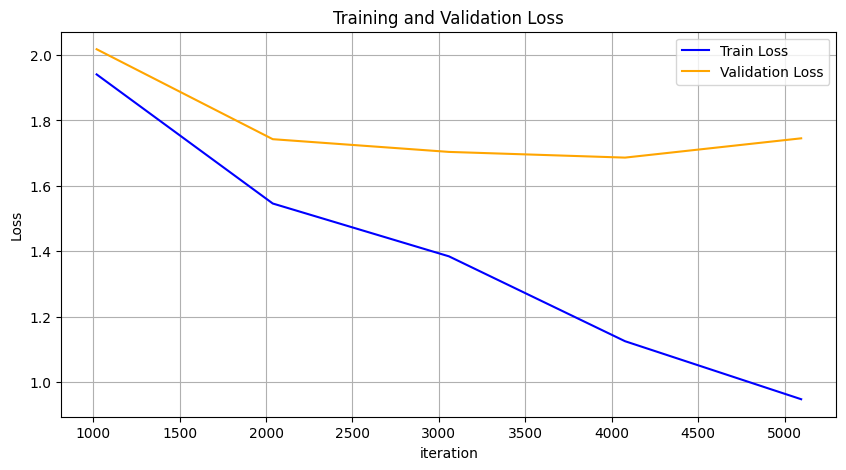

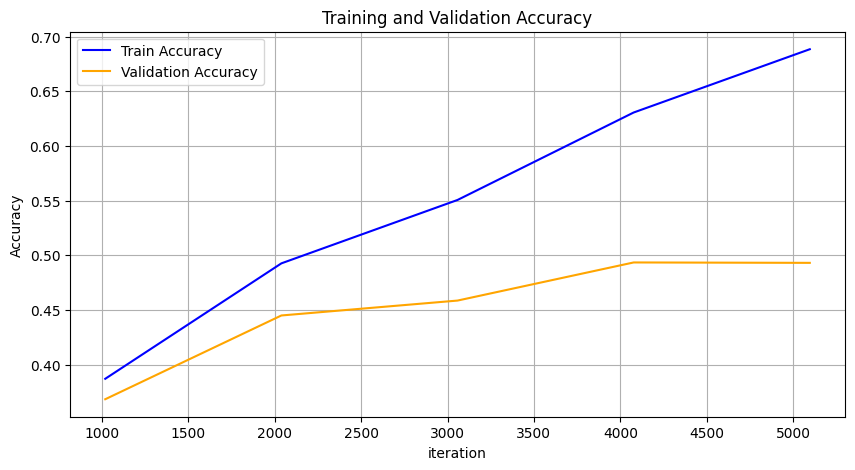

In [ ]:
# batch_size 256(larger) with resnet101
# saved as 'resnet_101_largeBatch'......
model = StyleResNet101_FC4()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet101_largeBatch', train_loader_large, val_loader_large, device, num_epochs = 5)

100%|██████████| 1019/1019 [05:42<00:00,  2.98it/s]

Epoch [1/2], Step [1019/1019], Training Loss: 0.7095, Training Accuracy: 0.7757, Validation Loss: 1.7077, Validation Accuracy: 0.5090



100%|██████████| 1019/1019 [05:42<00:00,  2.97it/s]

Epoch [2/2], Step [1019/1019], Training Loss: 0.5681, Training Accuracy: 0.8212, Validation Loss: 1.8189, Validation Accuracy: 0.5060


elapsed time: 685.6660301685333


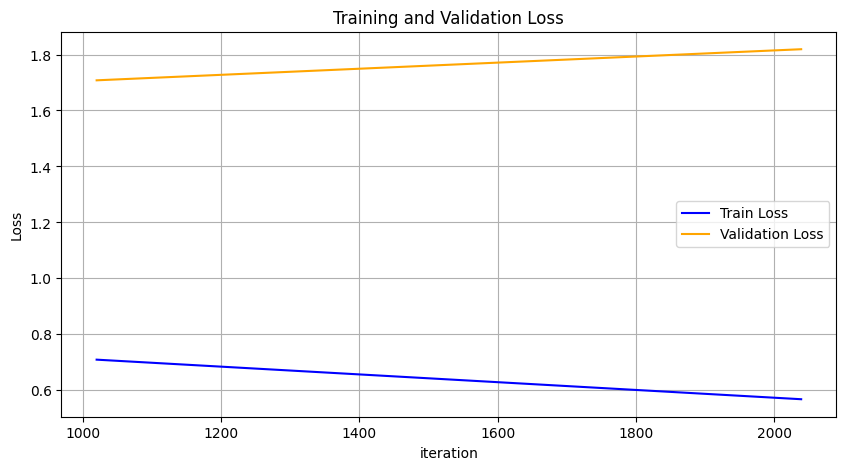

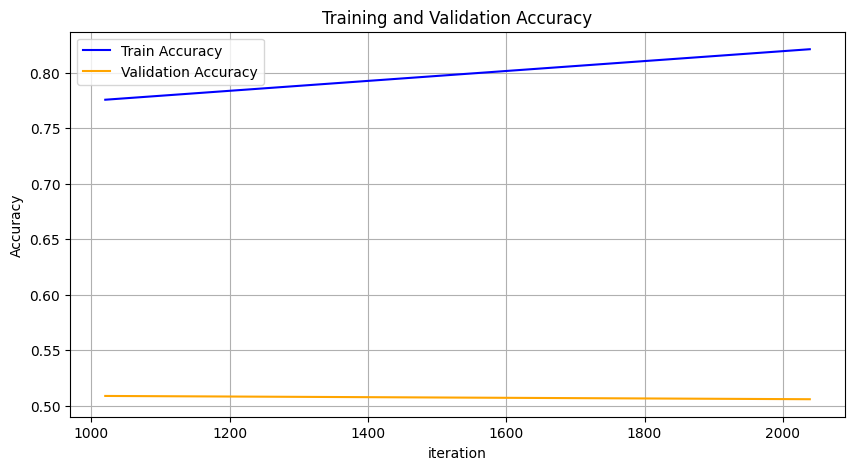

In [ ]:
model = joblib.load(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/resnet101_largeBatch_epoch5.joblib')
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet101_largeBatch_add', train_loader, val_loader, device, num_epochs = 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1019/1019 [05:39<00:00,  3.00it/s]

Epoch [1/5], Step [1019/1019], Training Loss: 2.2801, Training Accuracy: 0.2783, Validation Loss: 2.3014, Validation Accuracy: 0.2716



100%|██████████| 1019/1019 [05:38<00:00,  3.01it/s]

Epoch [2/5], Step [1019/1019], Training Loss: 2.1285, Training Accuracy: 0.3105, Validation Loss: 2.1709, Validation Accuracy: 0.3072



100%|██████████| 1019/1019 [05:37<00:00,  3.02it/s]

Epoch [3/5], Step [1019/1019], Training Loss: 2.5139, Training Accuracy: 0.2687, Validation Loss: 2.5975, Validation Accuracy: 0.2623



100%|██████████| 1019/1019 [05:40<00:00,  3.00it/s]

Epoch [4/5], Step [1019/1019], Training Loss: 1.9622, Training Accuracy: 0.3534, Validation Loss: 2.0347, Validation Accuracy: 0.3315



100%|██████████| 1019/1019 [05:39<00:00,  3.00it/s]

Epoch [5/5], Step [1019/1019], Training Loss: 1.8609, Training Accuracy: 0.3839, Validation Loss: 1.9887, Validation Accuracy: 0.3610


elapsed time: 1696.2091116905212


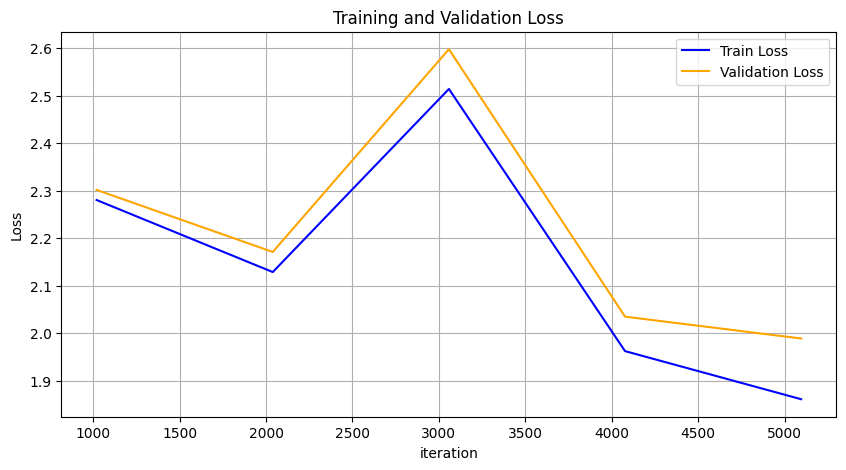

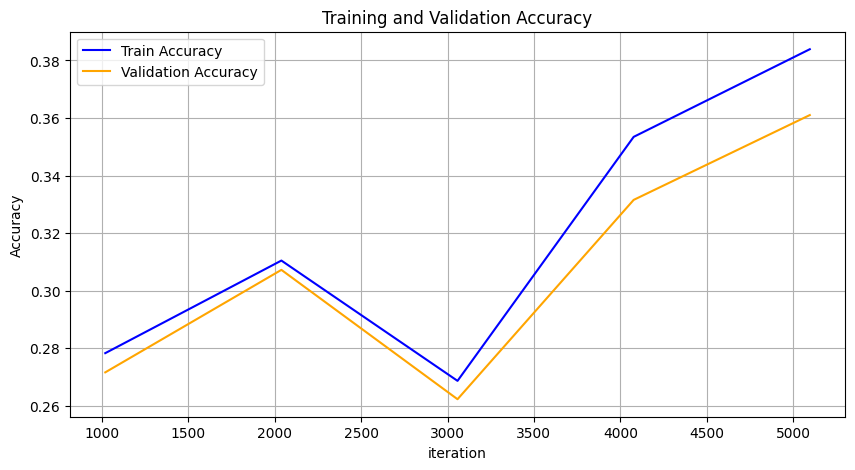

In [ ]:
# resnet101 with 4 fc layers
model = StyleResNet101_FC4()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet101_lr0.001', train_loader, val_loader, device, num_epochs = 5, lr=0.001)

100%|██████████| 1019/1019 [05:39<00:00,  3.00it/s]

Epoch [1/5], Step [1019/1019], Training Loss: 1.8381, Training Accuracy: 0.3966, Validation Loss: 1.8979, Validation Accuracy: 0.3851



100%|██████████| 1019/1019 [05:41<00:00,  2.99it/s]

Epoch [2/5], Step [1019/1019], Training Loss: 2.0297, Training Accuracy: 0.3669, Validation Loss: 2.1353, Validation Accuracy: 0.3517



100%|██████████| 1019/1019 [05:41<00:00,  2.98it/s]

Epoch [3/5], Step [1019/1019], Training Loss: 1.6571, Training Accuracy: 0.4465, Validation Loss: 1.8482, Validation Accuracy: 0.4008



100%|██████████| 1019/1019 [05:41<00:00,  2.98it/s]

Epoch [4/5], Step [1019/1019], Training Loss: 1.4347, Training Accuracy: 0.5182, Validation Loss: 1.7579, Validation Accuracy: 0.4451



100%|██████████| 1019/1019 [05:42<00:00,  2.98it/s]

Epoch [5/5], Step [1019/1019], Training Loss: 1.4800, Training Accuracy: 0.5089, Validation Loss: 1.9169, Validation Accuracy: 0.4334


elapsed time: 1706.8939785957336


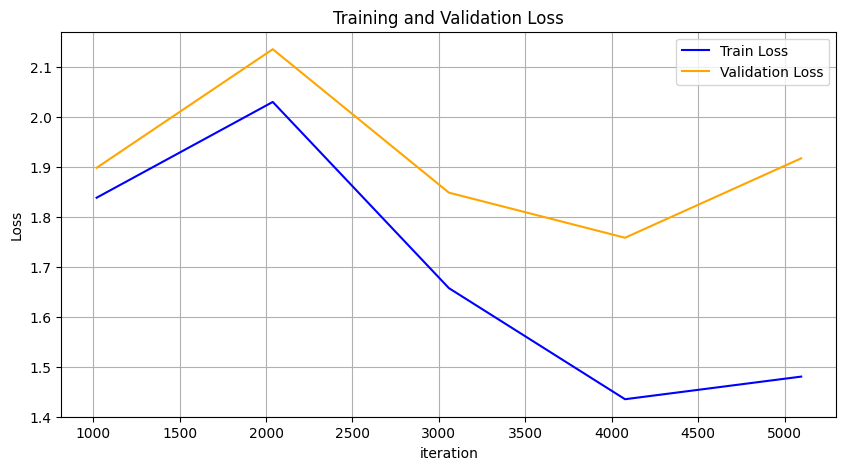

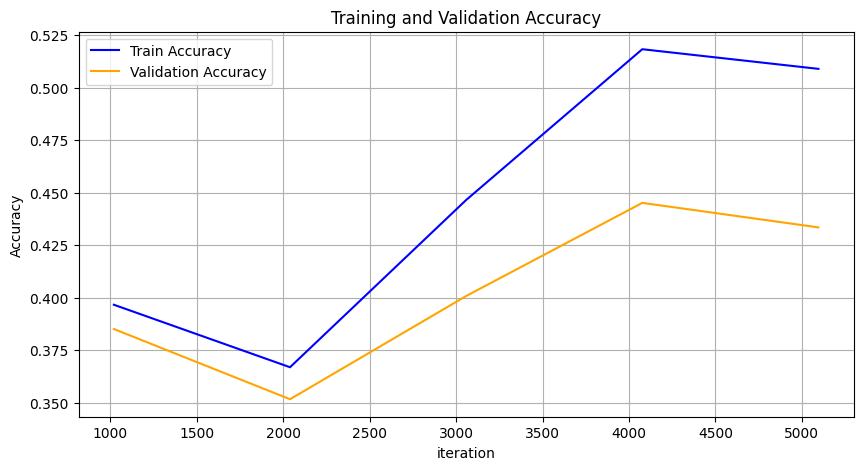

In [ ]:
# learning rate adjustment
model = StyleResNet18()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet18_lr0.001', train_loader, val_loader, device, num_epochs = 5, lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1019/1019 [05:46<00:00,  2.94it/s]

Epoch [1/5], Step [1019/1019], Training Loss: 1.9371, Training Accuracy: 0.4041, Validation Loss: 1.9884, Validation Accuracy: 0.3916



100%|██████████| 1019/1019 [05:42<00:00,  2.98it/s]

Epoch [2/5], Step [1019/1019], Training Loss: 1.6244, Training Accuracy: 0.4873, Validation Loss: 1.7256, Validation Accuracy: 0.4554



100%|██████████| 1019/1019 [05:43<00:00,  2.97it/s]

Epoch [3/5], Step [1019/1019], Training Loss: 1.4500, Training Accuracy: 0.5399, Validation Loss: 1.6062, Validation Accuracy: 0.4864



100%|██████████| 1019/1019 [05:38<00:00,  3.01it/s]

Epoch [4/5], Step [1019/1019], Training Loss: 1.3145, Training Accuracy: 0.5788, Validation Loss: 1.5391, Validation Accuracy: 0.5052



100%|██████████| 1019/1019 [05:38<00:00,  3.01it/s]

Epoch [5/5], Step [1019/1019], Training Loss: 1.2087, Training Accuracy: 0.6131, Validation Loss: 1.5102, Validation Accuracy: 0.5167


elapsed time: 1710.9888892173767


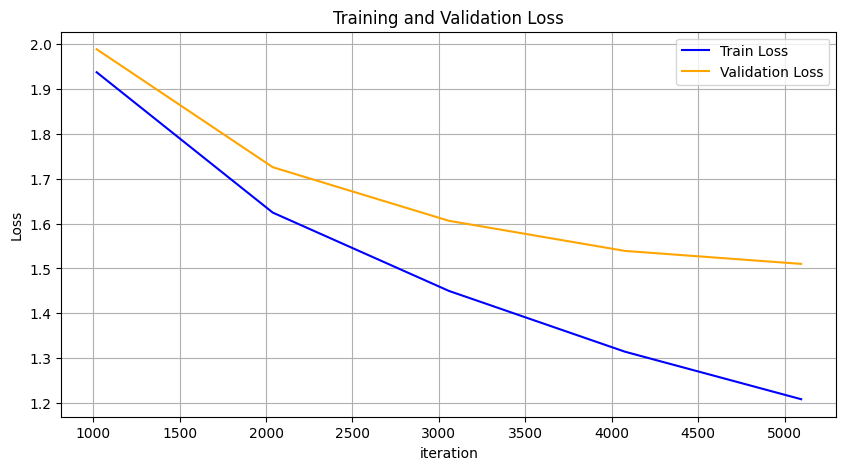

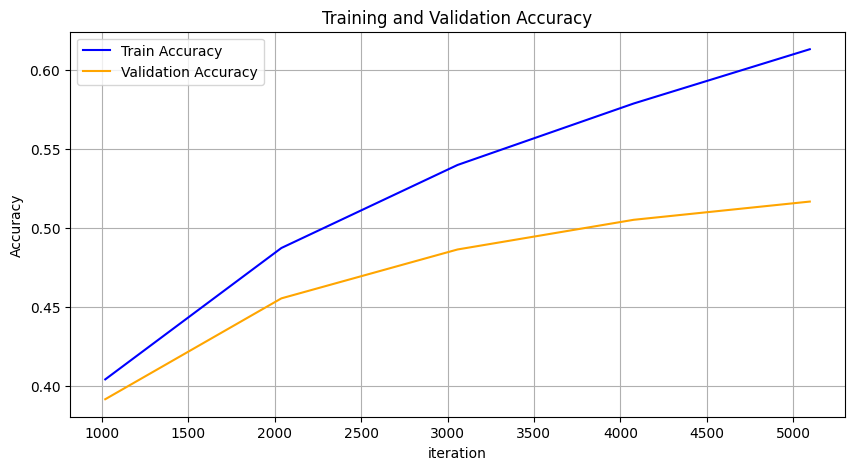

In [ ]:
# learning rate adjustment
model = StyleResNet18()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet101_lr0.00001', train_loader, val_loader, device, num_epochs = 5,lr=0.00001)

100%|██████████| 1019/1019 [05:39<00:00,  3.00it/s]

Epoch [1/8], Step [1019/1019], Training Loss: 1.0606, Training Accuracy: 0.6651, Validation Loss: 1.4659, Validation Accuracy: 0.5282



100%|██████████| 1019/1019 [05:38<00:00,  3.01it/s]

Epoch [2/8], Step [1019/1019], Training Loss: 0.9566, Training Accuracy: 0.6957, Validation Loss: 1.4713, Validation Accuracy: 0.5347



100%|██████████| 1019/1019 [05:42<00:00,  2.97it/s]

Epoch [3/8], Step [1019/1019], Training Loss: 0.8329, Training Accuracy: 0.7400, Validation Loss: 1.4668, Validation Accuracy: 0.5345



100%|██████████| 1019/1019 [05:43<00:00,  2.96it/s]

Epoch [4/8], Step [1019/1019], Training Loss: 0.7231, Training Accuracy: 0.7815, Validation Loss: 1.4932, Validation Accuracy: 0.5357



100%|██████████| 1019/1019 [05:46<00:00,  2.94it/s]

Epoch [5/8], Step [1019/1019], Training Loss: 0.6540, Training Accuracy: 0.8016, Validation Loss: 1.5374, Validation Accuracy: 0.5335



100%|██████████| 1019/1019 [05:38<00:00,  3.01it/s]

Epoch [6/8], Step [1019/1019], Training Loss: 0.5392, Training Accuracy: 0.8409, Validation Loss: 1.5926, Validation Accuracy: 0.5293



100%|██████████| 1019/1019 [05:40<00:00,  2.99it/s]

Epoch [7/8], Step [1019/1019], Training Loss: 0.4675, Training Accuracy: 0.8649, Validation Loss: 1.6599, Validation Accuracy: 0.5281



100%|██████████| 1019/1019 [05:39<00:00,  3.00it/s]

Epoch [8/8], Step [1019/1019], Training Loss: 0.3475, Training Accuracy: 0.9110, Validation Loss: 1.6836, Validation Accuracy: 0.5228


elapsed time: 2730.914087533951


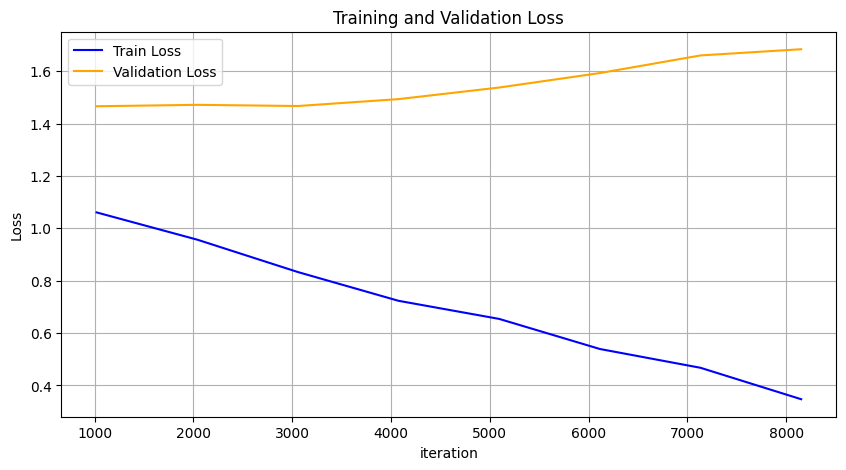

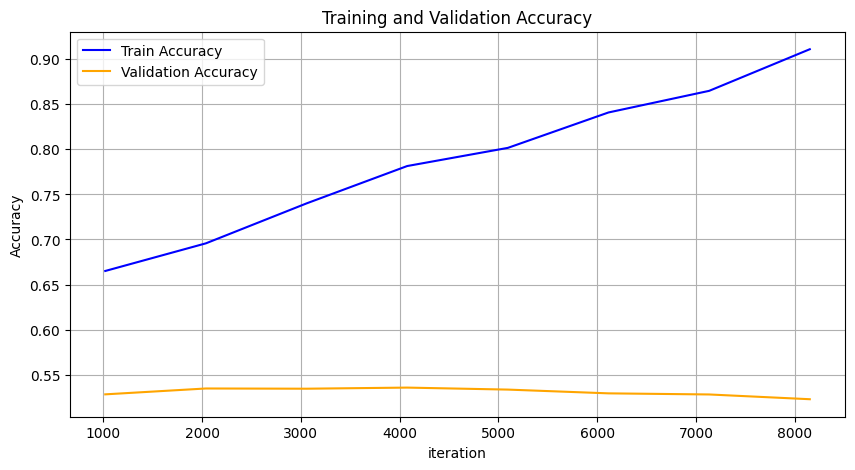

In [ ]:
model = joblib.load(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/resnet101_lr0.00001_epoch5.joblib')
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet101_lr0.00001add', train_loader, val_loader, device, num_epochs = 8, lr=0.00001)

In [ ]:
# subset class resnet 18
model = StyleResNet18()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'subset', train_loader_subset, val_loader_subset, device, num_epochs = 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 865/865 [02:51<00:00,  5.06it/s]


Epoch [1/5], Step [865/865], Training Loss: 1.1206, Training Accuracy: 0.6184, Validation Loss: 1.3280, Validation Accuracy: 0.5370


100%|██████████| 865/865 [02:51<00:00,  5.05it/s]


Epoch [2/5], Step [865/865], Training Loss: 0.7974, Training Accuracy: 0.7343, Validation Loss: 1.2228, Validation Accuracy: 0.5717


100%|██████████| 865/865 [02:51<00:00,  5.06it/s]


Epoch [3/5], Step [865/865], Training Loss: 0.5207, Training Accuracy: 0.8298, Validation Loss: 1.3122, Validation Accuracy: 0.5662


100%|██████████| 865/865 [02:50<00:00,  5.06it/s]


Epoch [4/5], Step [865/865], Training Loss: 0.3390, Training Accuracy: 0.8933, Validation Loss: 1.5107, Validation Accuracy: 0.5471


 25%|██▌       | 218/865 [00:43<02:09,  5.00it/s]


KeyboardInterrupt: 

100%|██████████| 865/865 [02:52<00:00,  5.02it/s]


Epoch [1/5], Step [865/865], Training Loss: 1.6501, Training Accuracy: 0.4585, Validation Loss: 1.6996, Validation Accuracy: 0.4388


100%|██████████| 865/865 [02:51<00:00,  5.04it/s]


Epoch [2/5], Step [865/865], Training Loss: 1.3607, Training Accuracy: 0.5447, Validation Loss: 1.4692, Validation Accuracy: 0.5014


100%|██████████| 865/865 [02:51<00:00,  5.04it/s]


Epoch [3/5], Step [865/865], Training Loss: 1.2014, Training Accuracy: 0.5932, Validation Loss: 1.3777, Validation Accuracy: 0.5337


100%|██████████| 865/865 [02:52<00:00,  5.01it/s]


Epoch [4/5], Step [865/865], Training Loss: 1.0679, Training Accuracy: 0.6402, Validation Loss: 1.3197, Validation Accuracy: 0.5471


100%|██████████| 865/865 [02:52<00:00,  5.02it/s]


Epoch [5/5], Step [865/865], Training Loss: 0.9479, Training Accuracy: 0.6833, Validation Loss: 1.2928, Validation Accuracy: 0.5554
elapsed time: 1428.499647140503


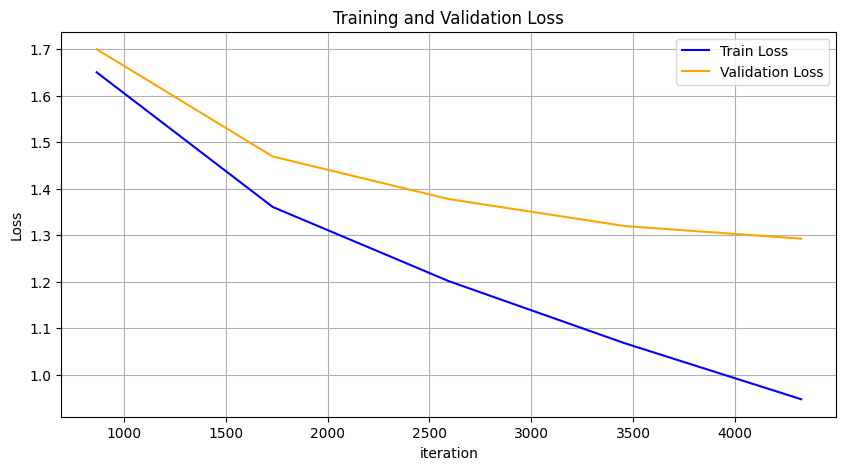

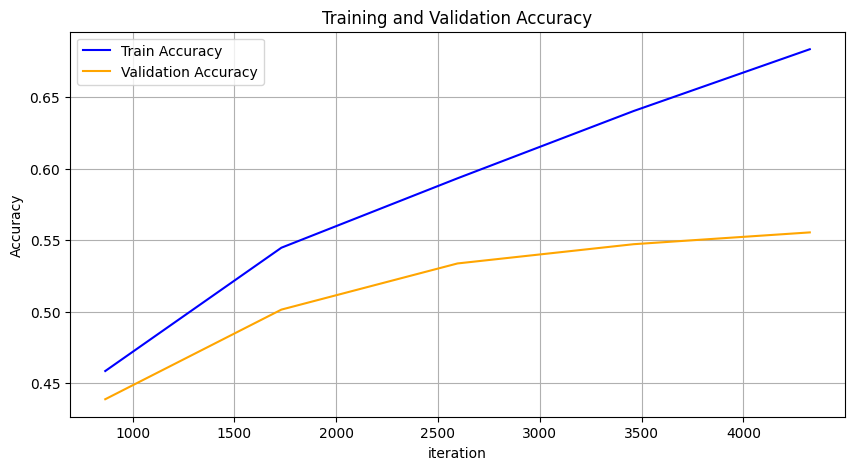

In [ ]:
# subset class resnet, learning rate adjustment
model = StyleResNet18()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'subset_lr0.00001', train_loader_subset, val_loader_subset, device, num_epochs = 5, lr=0.00001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 865/865 [09:12<00:00,  1.57it/s]


Epoch [1/5], Step [865/865], Training Loss: 1.2363, Training Accuracy: 0.5783, Validation Loss: 1.4013, Validation Accuracy: 0.5166


100%|██████████| 865/865 [09:11<00:00,  1.57it/s]


Epoch [2/5], Step [865/865], Training Loss: 0.9060, Training Accuracy: 0.6876, Validation Loss: 1.2680, Validation Accuracy: 0.5597


100%|██████████| 865/865 [09:12<00:00,  1.57it/s]


Epoch [3/5], Step [865/865], Training Loss: 0.5916, Training Accuracy: 0.8086, Validation Loss: 1.2450, Validation Accuracy: 0.5836


100%|██████████| 865/865 [09:12<00:00,  1.57it/s]


Epoch [4/5], Step [865/865], Training Loss: 0.4373, Training Accuracy: 0.8537, Validation Loss: 1.3674, Validation Accuracy: 0.5762


100%|██████████| 865/865 [09:10<00:00,  1.57it/s]


Epoch [5/5], Step [865/865], Training Loss: 0.2824, Training Accuracy: 0.9133, Validation Loss: 1.4763, Validation Accuracy: 0.5743
elapsed time: 3687.9377591609955


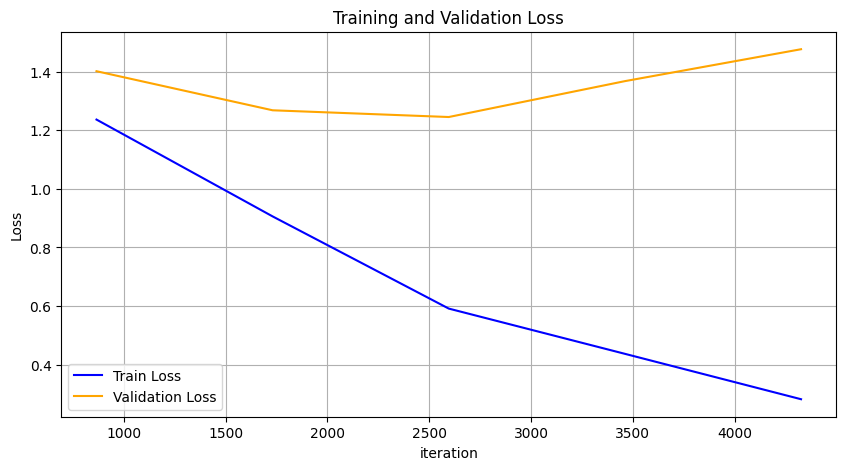

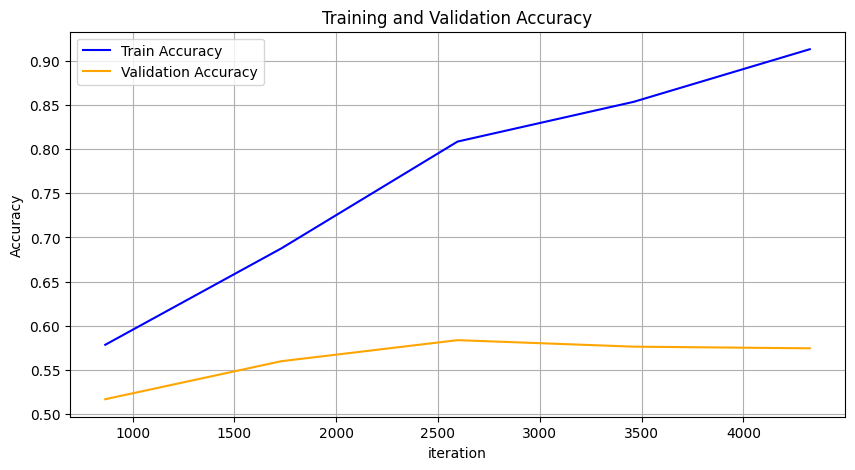

In [ ]:
# resnet50, subsetclass
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet50_wo_l2', train_loader_subset, val_loader_subset, device, num_epochs = 5)

In [ ]:
# resnet50, subset class, weight decay
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet50', train_loader_subset, val_loader_subset, device, num_epochs = 5,wd=0.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 865/865 [09:13<00:00,  1.56it/s]


Epoch [1/5], Step [865/865], Training Loss: 2.6019, Training Accuracy: 0.1887, Validation Loss: 2.6095, Validation Accuracy: 0.1849


100%|██████████| 865/865 [09:05<00:00,  1.58it/s]


Epoch [2/5], Step [865/865], Training Loss: 2.4376, Training Accuracy: 0.1887, Validation Loss: 2.4438, Validation Accuracy: 0.1849


100%|██████████| 865/865 [08:54<00:00,  1.62it/s]


Epoch [3/5], Step [865/865], Training Loss: 2.7966, Training Accuracy: 0.1899, Validation Loss: 2.7998, Validation Accuracy: 0.1861


100%|██████████| 865/865 [08:45<00:00,  1.65it/s]


Epoch [4/5], Step [865/865], Training Loss: 2.5884, Training Accuracy: 0.1887, Validation Loss: 2.5962, Validation Accuracy: 0.1849


 30%|██▉       | 258/865 [02:35<06:05,  1.66it/s]


KeyboardInterrupt: 

In [ ]:
# resnet50,subset class, weight decay
model = StyleResNet50()
trained_model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, 'resnet50_wd0.001', train_loader_subset, val_loader_subset, device, num_epochs = 8, wd=0.001)

100%|██████████| 865/865 [09:13<00:00,  1.56it/s]


Epoch [1/8], Step [865/865], Training Loss: 1.2257, Training Accuracy: 0.5826, Validation Loss: 1.3948, Validation Accuracy: 0.5085


100%|██████████| 865/865 [09:12<00:00,  1.56it/s]


Epoch [2/8], Step [865/865], Training Loss: 0.9468, Training Accuracy: 0.6805, Validation Loss: 1.2763, Validation Accuracy: 0.5542


100%|██████████| 865/865 [09:11<00:00,  1.57it/s]


Epoch [3/8], Step [865/865], Training Loss: 0.7924, Training Accuracy: 0.7257, Validation Loss: 1.3605, Validation Accuracy: 0.5471


100%|██████████| 865/865 [09:11<00:00,  1.57it/s]


Epoch [4/8], Step [865/865], Training Loss: 0.5883, Training Accuracy: 0.8131, Validation Loss: 1.3890, Validation Accuracy: 0.5435


100%|██████████| 865/865 [09:11<00:00,  1.57it/s]


KeyboardInterrupt: 

# Evaluate Function

In [ ]:
def precision_at_k(y_true, y_pred, k=3):
    top_k_indices = np.argsort(y_pred, axis=1)[:, -k:]  # Get indices of top k predictions for each example
    num_examples = len(y_true)
    correct_predictions = 0
    for i in range(num_examples):
        if y_true[i] in top_k_indices[i]:
            correct_predictions += 1
    precision = correct_predictions
    return precision

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_precision = 0
    total_correct = 0
    total_samples = 0
    y_hat_epoch = []
    y_true_epoch = []

    i = 0

    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():

        for data, labels in data_loader:
          data, labels = data.to(device), labels.to(device)
          output = model(data)
          loss = criterion(output, labels)
          total_loss += loss.item() * data.size(0)

          pred = output.max(1, keepdim=True)[1]
          total_correct += pred.eq(labels.view_as(pred)).sum().item()

          precision = precision_at_k(labels.cpu().numpy(), output.cpu().numpy(), k=3)
          total_precision += precision

          total_samples += data.size(0)
          y_hat_epoch.append(pred.cpu().numpy())
          y_true_epoch.append(labels.cpu().numpy())

    y_hat_epoch = np.concatenate(y_hat_epoch, axis=None)
    y_true_epoch = np.concatenate(y_true_epoch, axis=None)

    precision_k = total_precision / total_samples
    average_loss = total_loss / total_samples
    accuracies = total_correct / total_samples
    scores = precision_recall_fscore_support(np.array(y_true_epoch), np.array(y_hat_epoch))
    results = pd.DataFrame({'loss': average_loss, 'accuracy': accuracies, 'topk': precision_k,
                            'precision': scores[0], 'recall': scores[1], 'f1': scores[2]})
    #results.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/Metrics results.csv')

    return average_loss, accuracies, precision_k, scores, y_true_epoch, y_hat_epoch,

# Evaluate

### metrics

In [ ]:
best_model = joblib.load(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/resnet50_wo_l2_epoch3.joblib')
train_average_loss, train_accuracies, train_precision_k, train_scores, y_ture_train, y_hat_train = evaluate_model(best_model, train_loader_subset, device)

In [ ]:
val_average_loss, val_accuracies, val_precision_k, val_scores, y_true_val, y_hat_val = evaluate_model(best_model, val_loader_subset, device)
test_average_loss, test_accuracies, test_precision_k, test_scores, y_true_test, y_hat_test = evaluate_model(best_model, test_loader_subset, device)

In [ ]:
losses = pd.DataFrame({'losses': [train_average_loss, val_average_loss, test_average_loss],
                       'accuracy': [train_accuracies, val_accuracies, test_accuracies],
                       'k accuracy': [train_precision_k, val_precision_k, test_precision_k]})
losses.index = ['train', 'val', 'test']

losses.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/metrics/losses.csv')

In [ ]:
losses

,losses,accuracy,k accuracy
train,0.591562,0.808632,0.963292
val,1.245010,0.583574,0.858589
test,1.234070,0.593321,0.857164


In [ ]:
precision_metrics = pd.DataFrame({'train precision': train_scores[0], 'val precision': val_scores[0], 'test precision': test_scores[0],
                                  'train recall':train_scores[1], 'val recall': val_scores[1], 'test recall': test_scores[1],
                                  'train f1': train_scores[2], 'val f1': val_scores[2], 'test f1': test_scores[2]})
precision_metrics.index =  used_class
precision_metrics.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/metrics/precision metrics.csv')

In [ ]:
precision_metrics

,train precision,val precision,test precision,train recall,val recall,test recall,train f1,val f1,test f1
Abstract_Expressionism,0.851133,0.674121,0.651007,0.946043,0.758993,0.692857,0.896082,0.714044,0.671280
Art_Nouveau_Modern,0.810532,0.536765,0.600000,0.816138,0.522673,0.579775,0.813326,0.529625,0.589714
Baroque,0.861182,0.646919,0.636156,0.893779,0.659420,0.665072,0.877178,0.653110,0.650292
Cubism,0.842197,0.627451,0.669903,0.826901,0.554113,0.570248,0.834479,0.588506,0.616071
Expressionism,0.781356,0.497521,0.511364,0.723601,0.441349,0.480183,0.751371,0.467754,0.495283
Impressionism,0.803947,0.621005,0.650193,0.885813,0.744332,0.755970,0.842897,0.677098,0.699103
Naive_Art_Primitivism,0.700426,0.473186,0.460064,0.841083,0.655022,0.657534,0.764337,0.549451,0.541353
Northern_Renaissance,0.825787,0.629851,0.602446,0.948959,0.742958,0.788000,0.883099,0.681745,0.682842
Post_Impressionism,0.697283,0.471086,0.452744,0.702390,0.508371,0.490909,0.699827,0.489019,0.471055
Realism,0.830296,0.592145,0.612103,0.796156,0.549020,0.572888,0.812868,0.569767,0.591847


### confusion matrix

In [ ]:
def plot_confusion(Y_hat, Y_test, classes, title):
  '''input: Y_hat, Y_test: list
            raw_datset: ImageFoldered data'''

  C = confusion_matrix(Y_test, Y_hat)

  C_df = pd.DataFrame(C,
                       index = classes,
                       columns = classes)

  plt.figure(figsize=(11,10), dpi=300)
  sns.heatmap(C_df, annot=True, fmt='d', cmap='Blues')
  plt.title(f'Confusion Matrix of {title}')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()
  return C

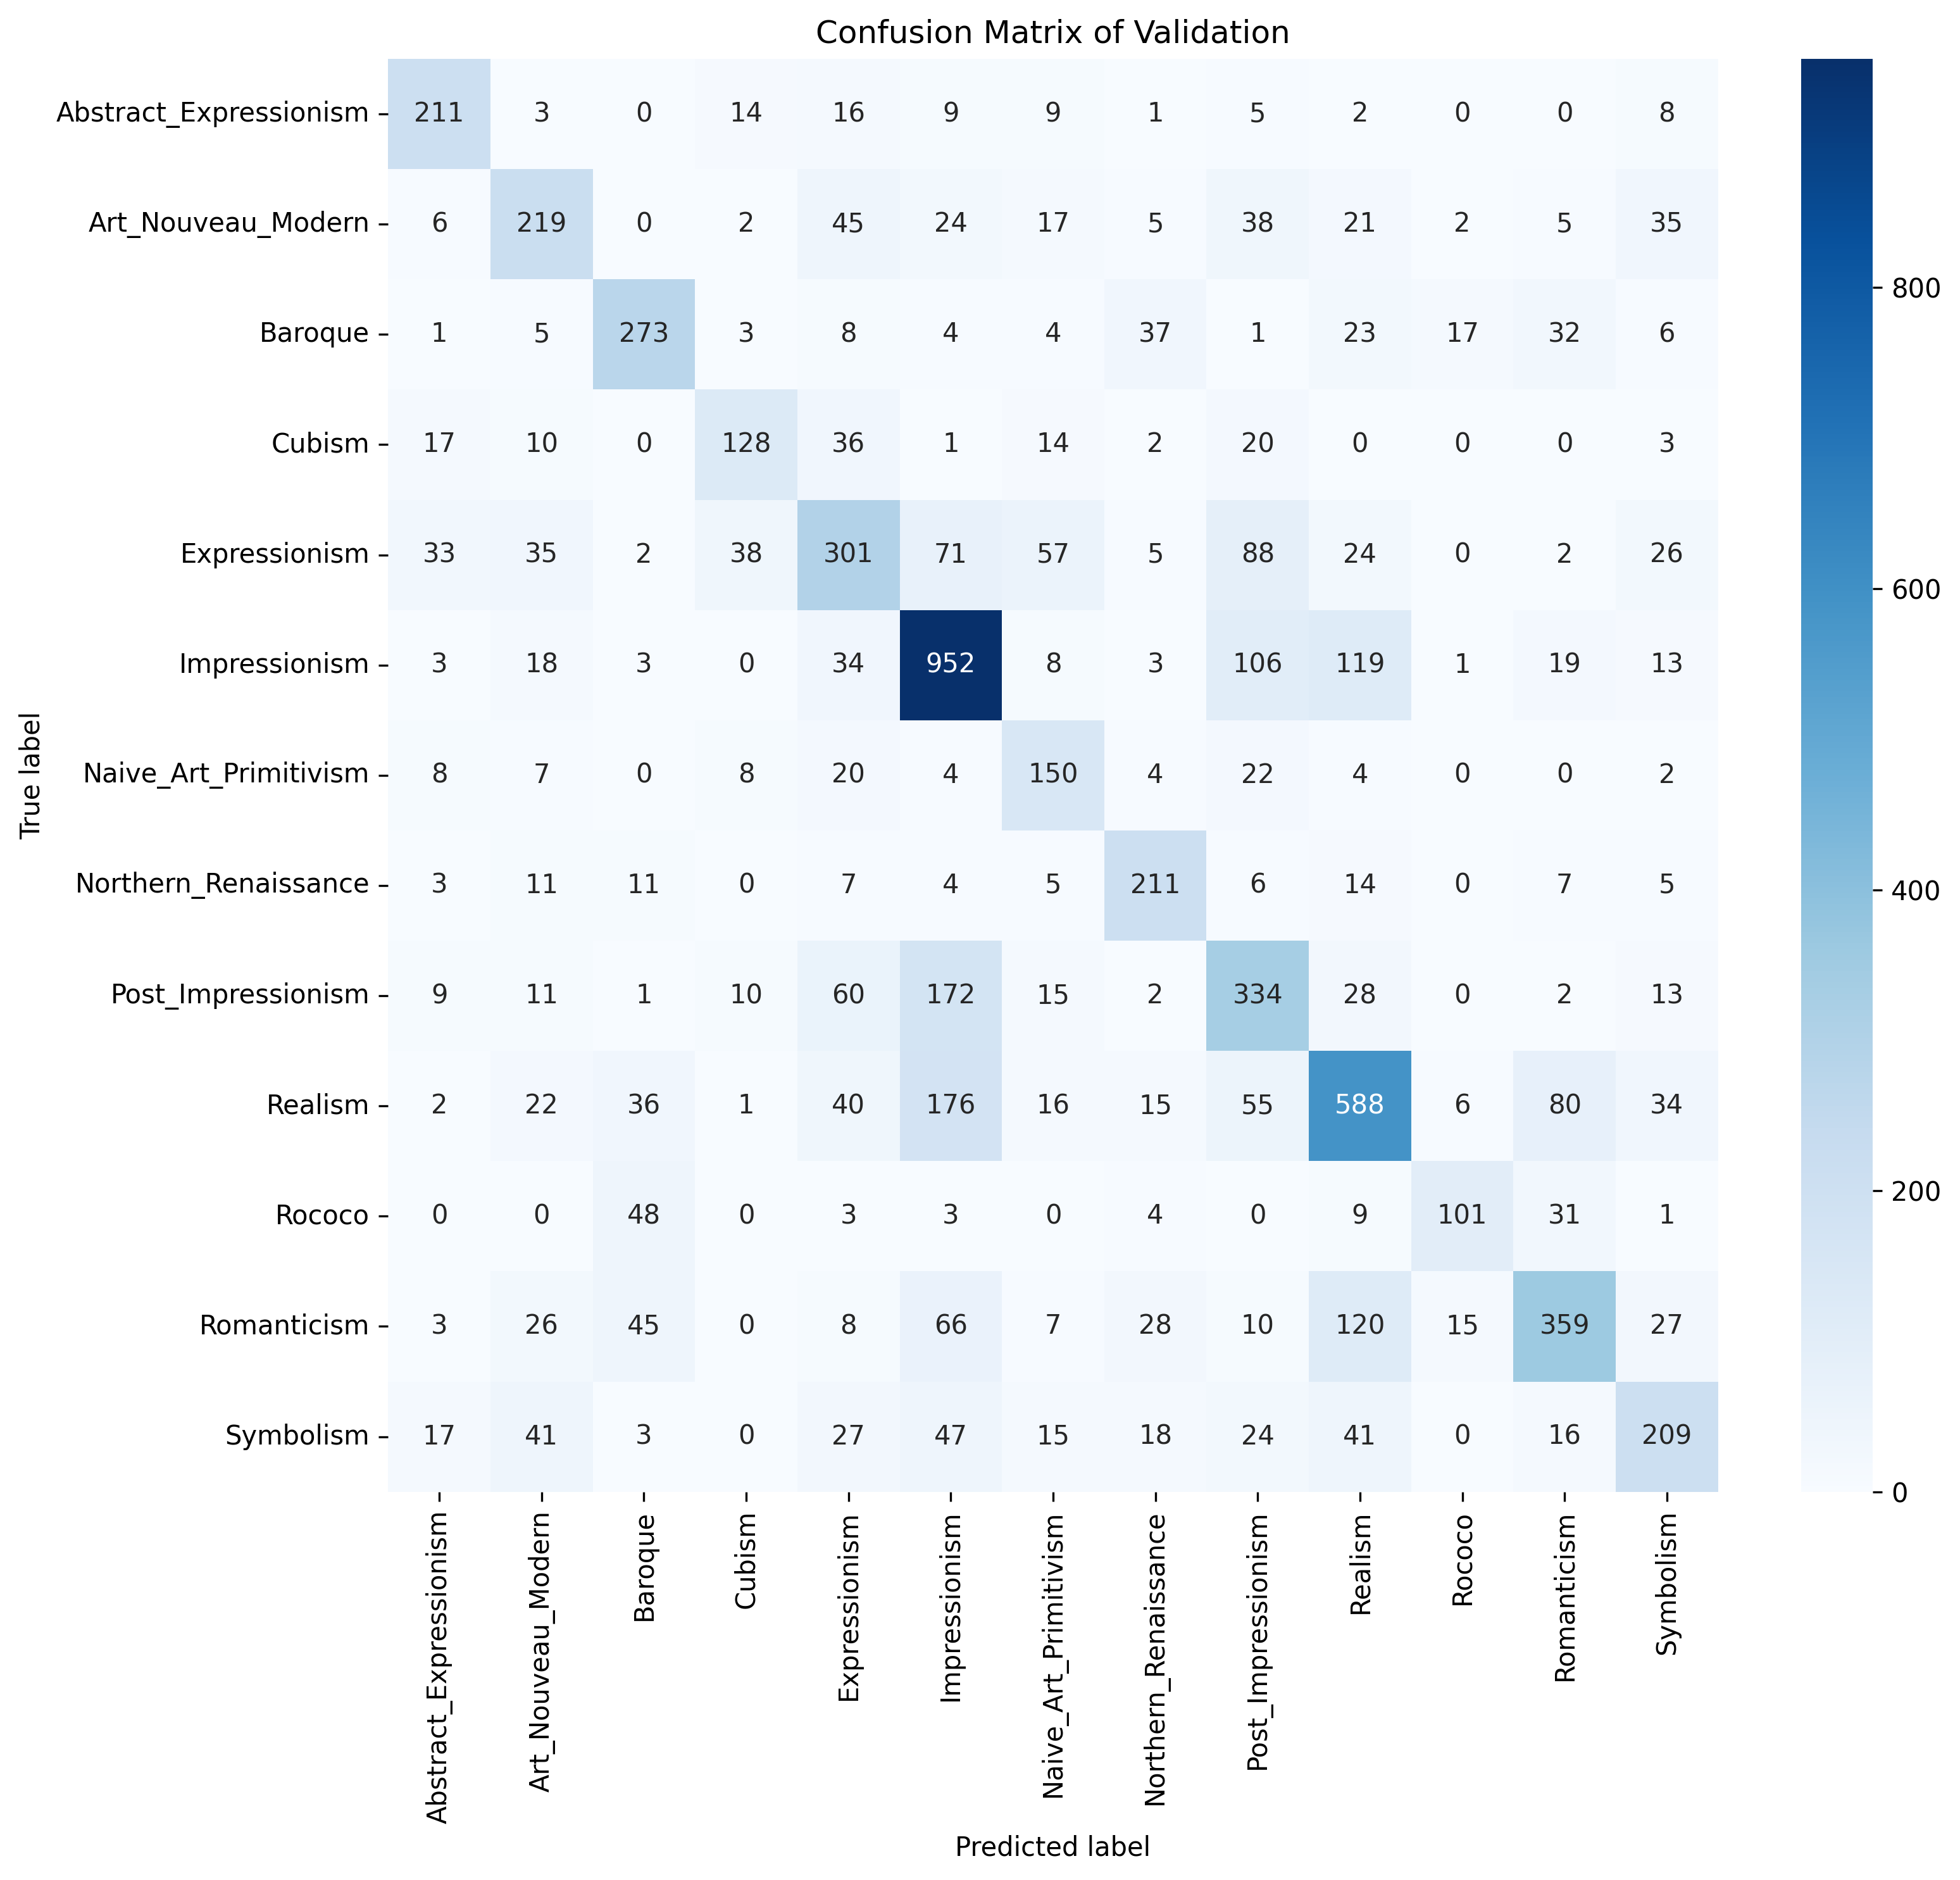

In [ ]:
C_val = plot_confusion(y_hat_val, y_true_val, used_class, 'Validation')

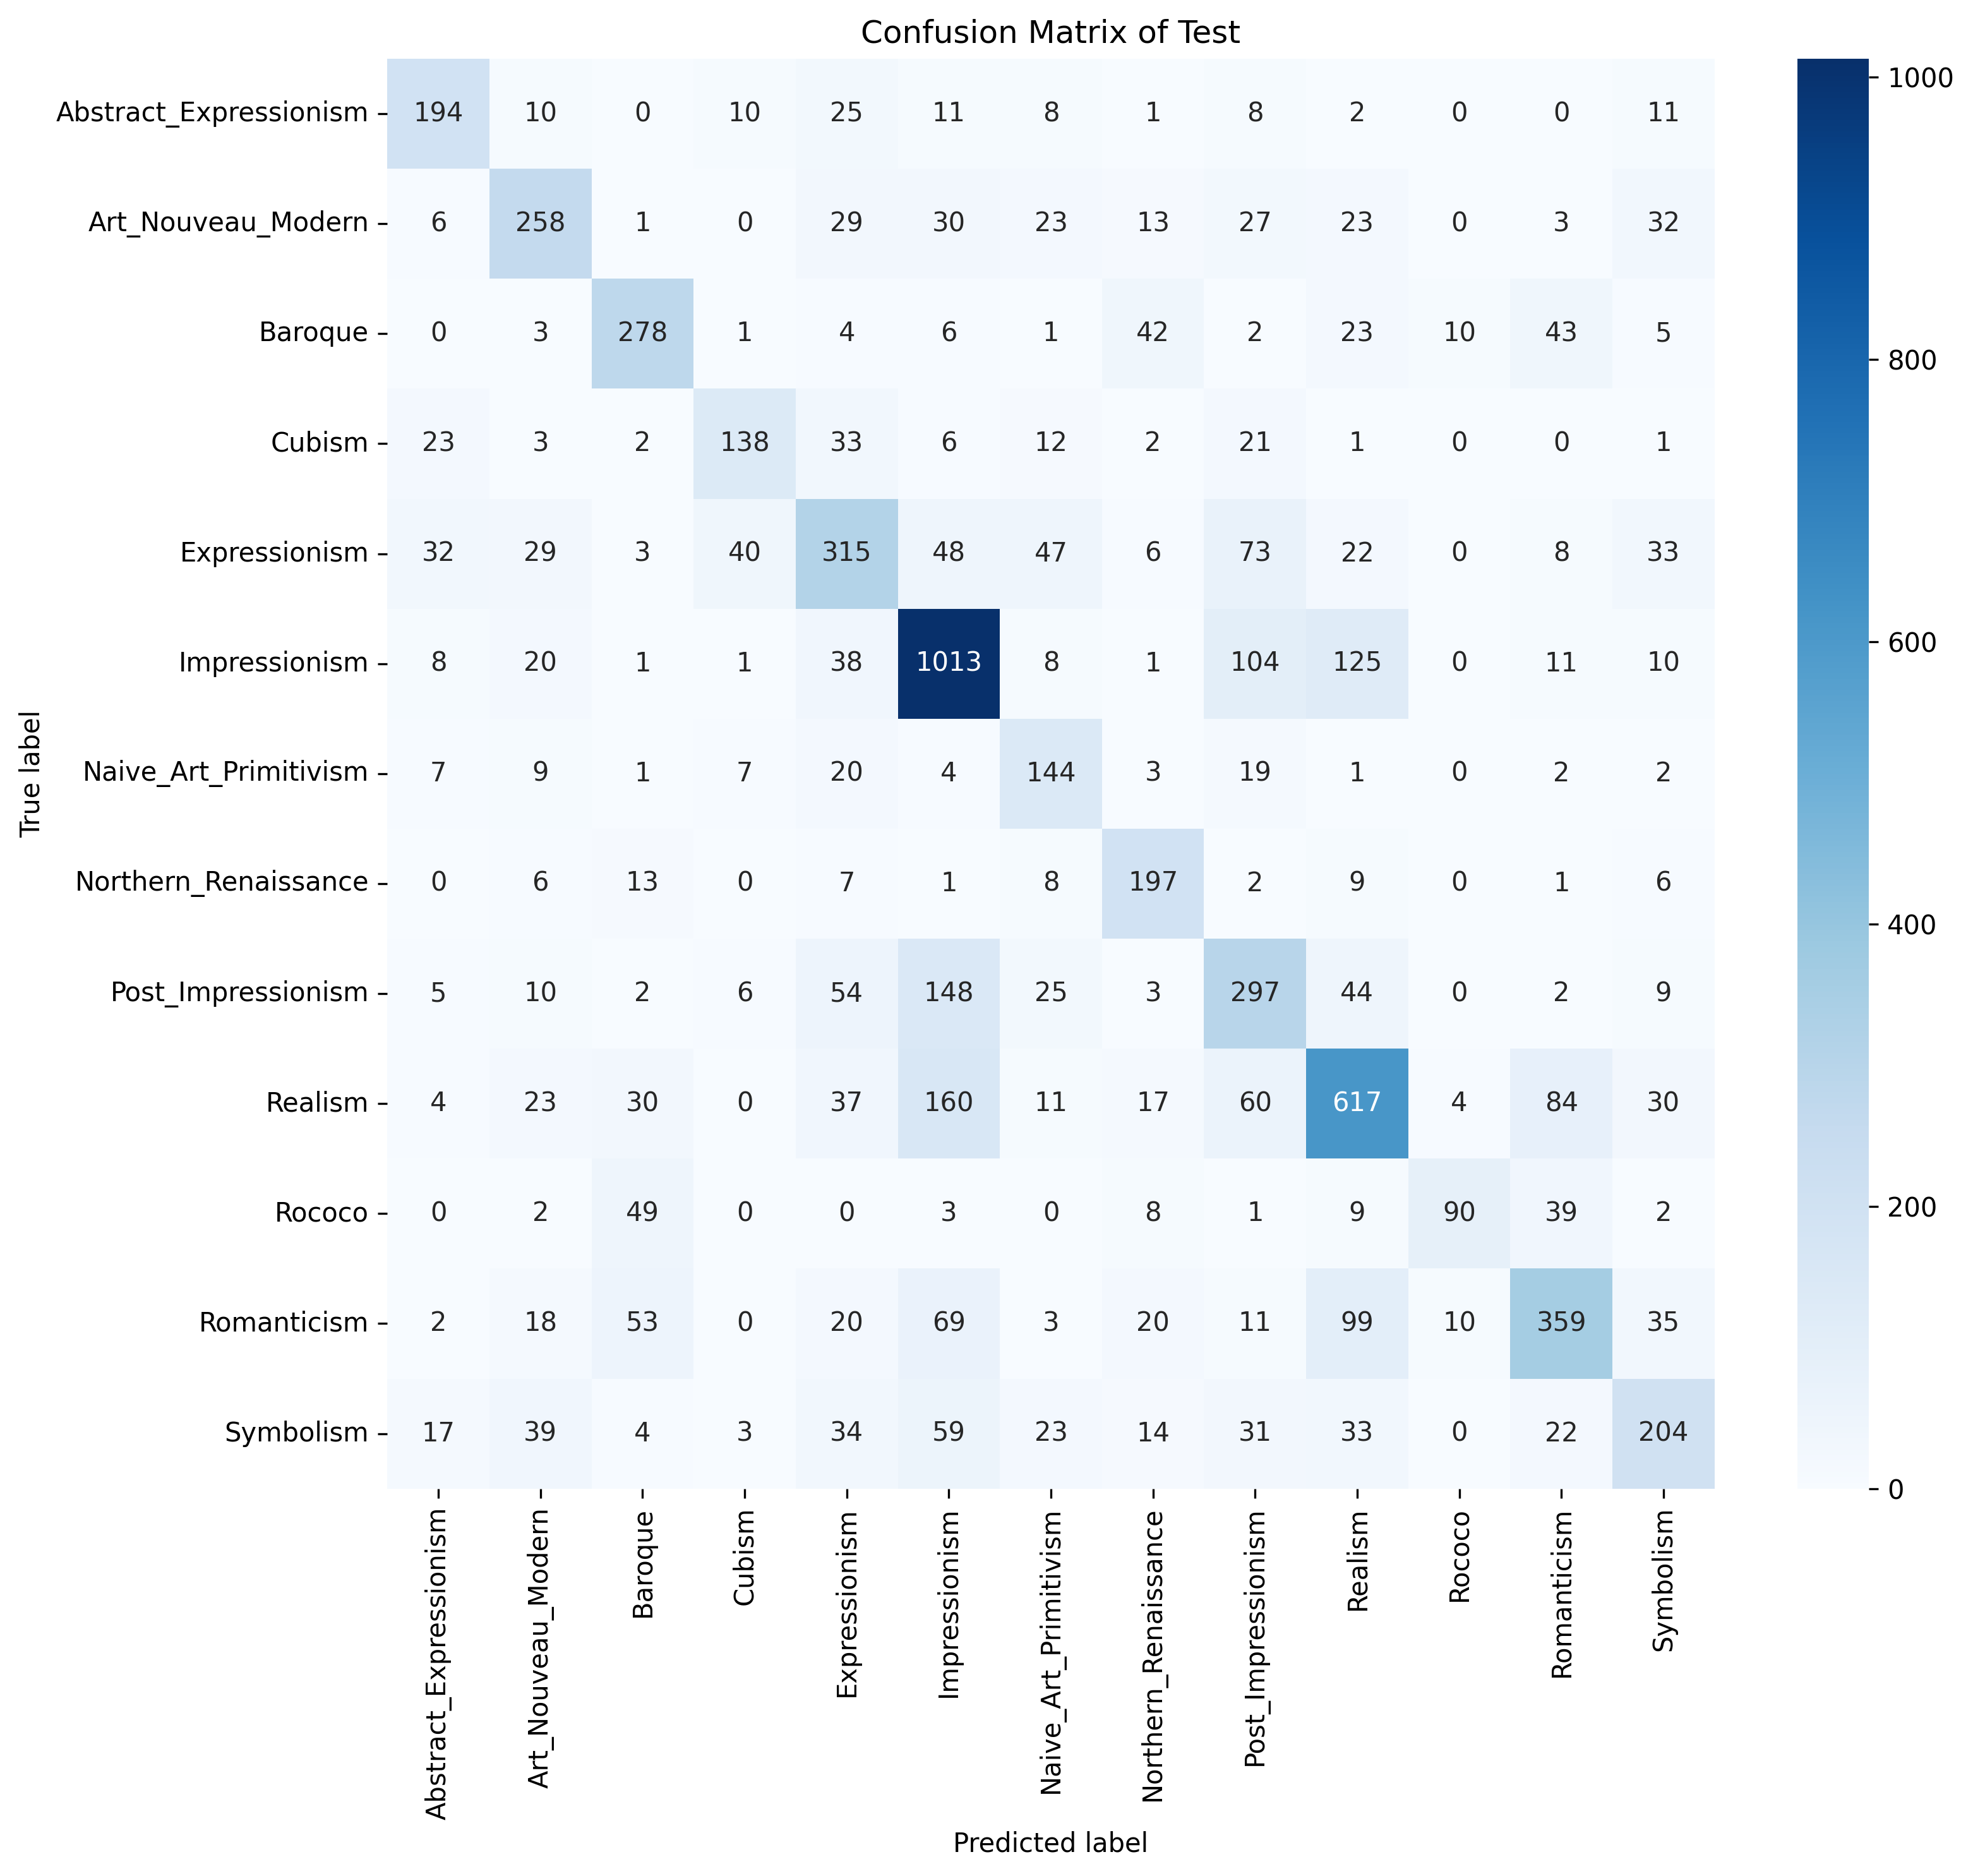

In [ ]:
C_test = plot_confusion(y_hat_test, y_true_test, used_class, 'Test')

### predicted labels

In [ ]:
value_to_category = {
    0: 'Abstract_Expressionism',
    3: 'Art_Nouveau_Modern',
    4: 'Baroque',
    7: 'Cubism',
    9: 'Expressionism',
    12: 'Impressionism',
    15: 'Naive_Art_Primitivism',
    17: 'Northern_Renaissance',
    20: 'Post_Impressionism',
    21: 'Realism',
    22: 'Rococo',
    23: 'Romanticism',
    24: 'Symbolism'
}
class_numbers = list(value_to_category.keys())

predicted = pd.DataFrame()
for true_label in class_numbers:
  indices = np.where(y_true_test == true_label)[0]

  elements = y_hat_test[indices]
  counter = Counter(elements)
  sorted_counter = sorted(counter.items(), key=lambda x: x[0])
  for i in range(len(value_to_category)):
    if sorted_counter[i][0] != class_numbers[i]:
      sorted_counter.append((class_numbers[i], 0))
      sorted_counter = sorted(sorted_counter, key=lambda x: x[0])
 # print(sorted_counter)
  counts = []
  for value, count in sorted_counter:
      counts.append(count)

  while len(counts) < 12:
        counts.append(np.nan)
  predicted[f'{value_to_category[true_label]}'] = counts
predicted.index = used_class
predicted.index.name = 'predicted class'

predicted.to_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/metrics/predicted classes.csv')

In [ ]:
predicted

,Abstract_Expressionism,Art_Nouveau_Modern,Baroque,Cubism,Expressionism,Impressionism,Naive_Art_Primitivism,Northern_Renaissance,Post_Impressionism,Realism,Rococo,Romanticism,Symbolism
predicted class,,,,,,,,,,,,,
Abstract_Expressionism,194,6,0,23,32,8,7,0,5,4,0,2,17
Art_Nouveau_Modern,10,258,3,3,29,20,9,6,10,23,2,18,39
Baroque,0,1,278,2,3,1,1,13,2,30,49,53,4
Cubism,10,0,1,138,40,1,7,0,6,0,0,0,3
Expressionism,25,29,4,33,315,38,20,7,54,37,0,20,34
Impressionism,11,30,6,6,48,1013,4,1,148,160,3,69,59
Naive_Art_Primitivism,8,23,1,12,47,8,144,8,25,11,0,3,23
Northern_Renaissance,1,13,42,2,6,1,3,197,3,17,8,20,14
Post_Impressionism,8,27,2,21,73,104,19,2,297,60,1,11,31


In [ ]:
curve = pd.read_csv(f'/content/drive/MyDrive/UofT/MIE1517/project/fine_tune/resnet50_wo_l2_results.csv')
curve

,Unnamed: 0,train loss,valid loss,train accuracy,valid accuracy,iteration
0,0,1.236285,1.401271,0.578333,0.516628,866
1,1,0.905961,1.267968,0.687627,0.559717,1731
2,2,0.591562,1.245010,0.808632,0.583574,2596
3,3,0.437250,1.367412,0.853673,0.576200,3461
4,4,0.282420,1.476270,0.913299,0.574320,4326


In [ ]:
def plot_curves(train_losses, valid_losses, train_accuracies, valid_accuracies):
    epochs = range(1, len(train_losses) + 1)
    # Plot Loss Curve
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, valid_losses, label='Validation Loss', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot Accuracy Curve
    plt.figure(figsize=(10, 5), dpi=300)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

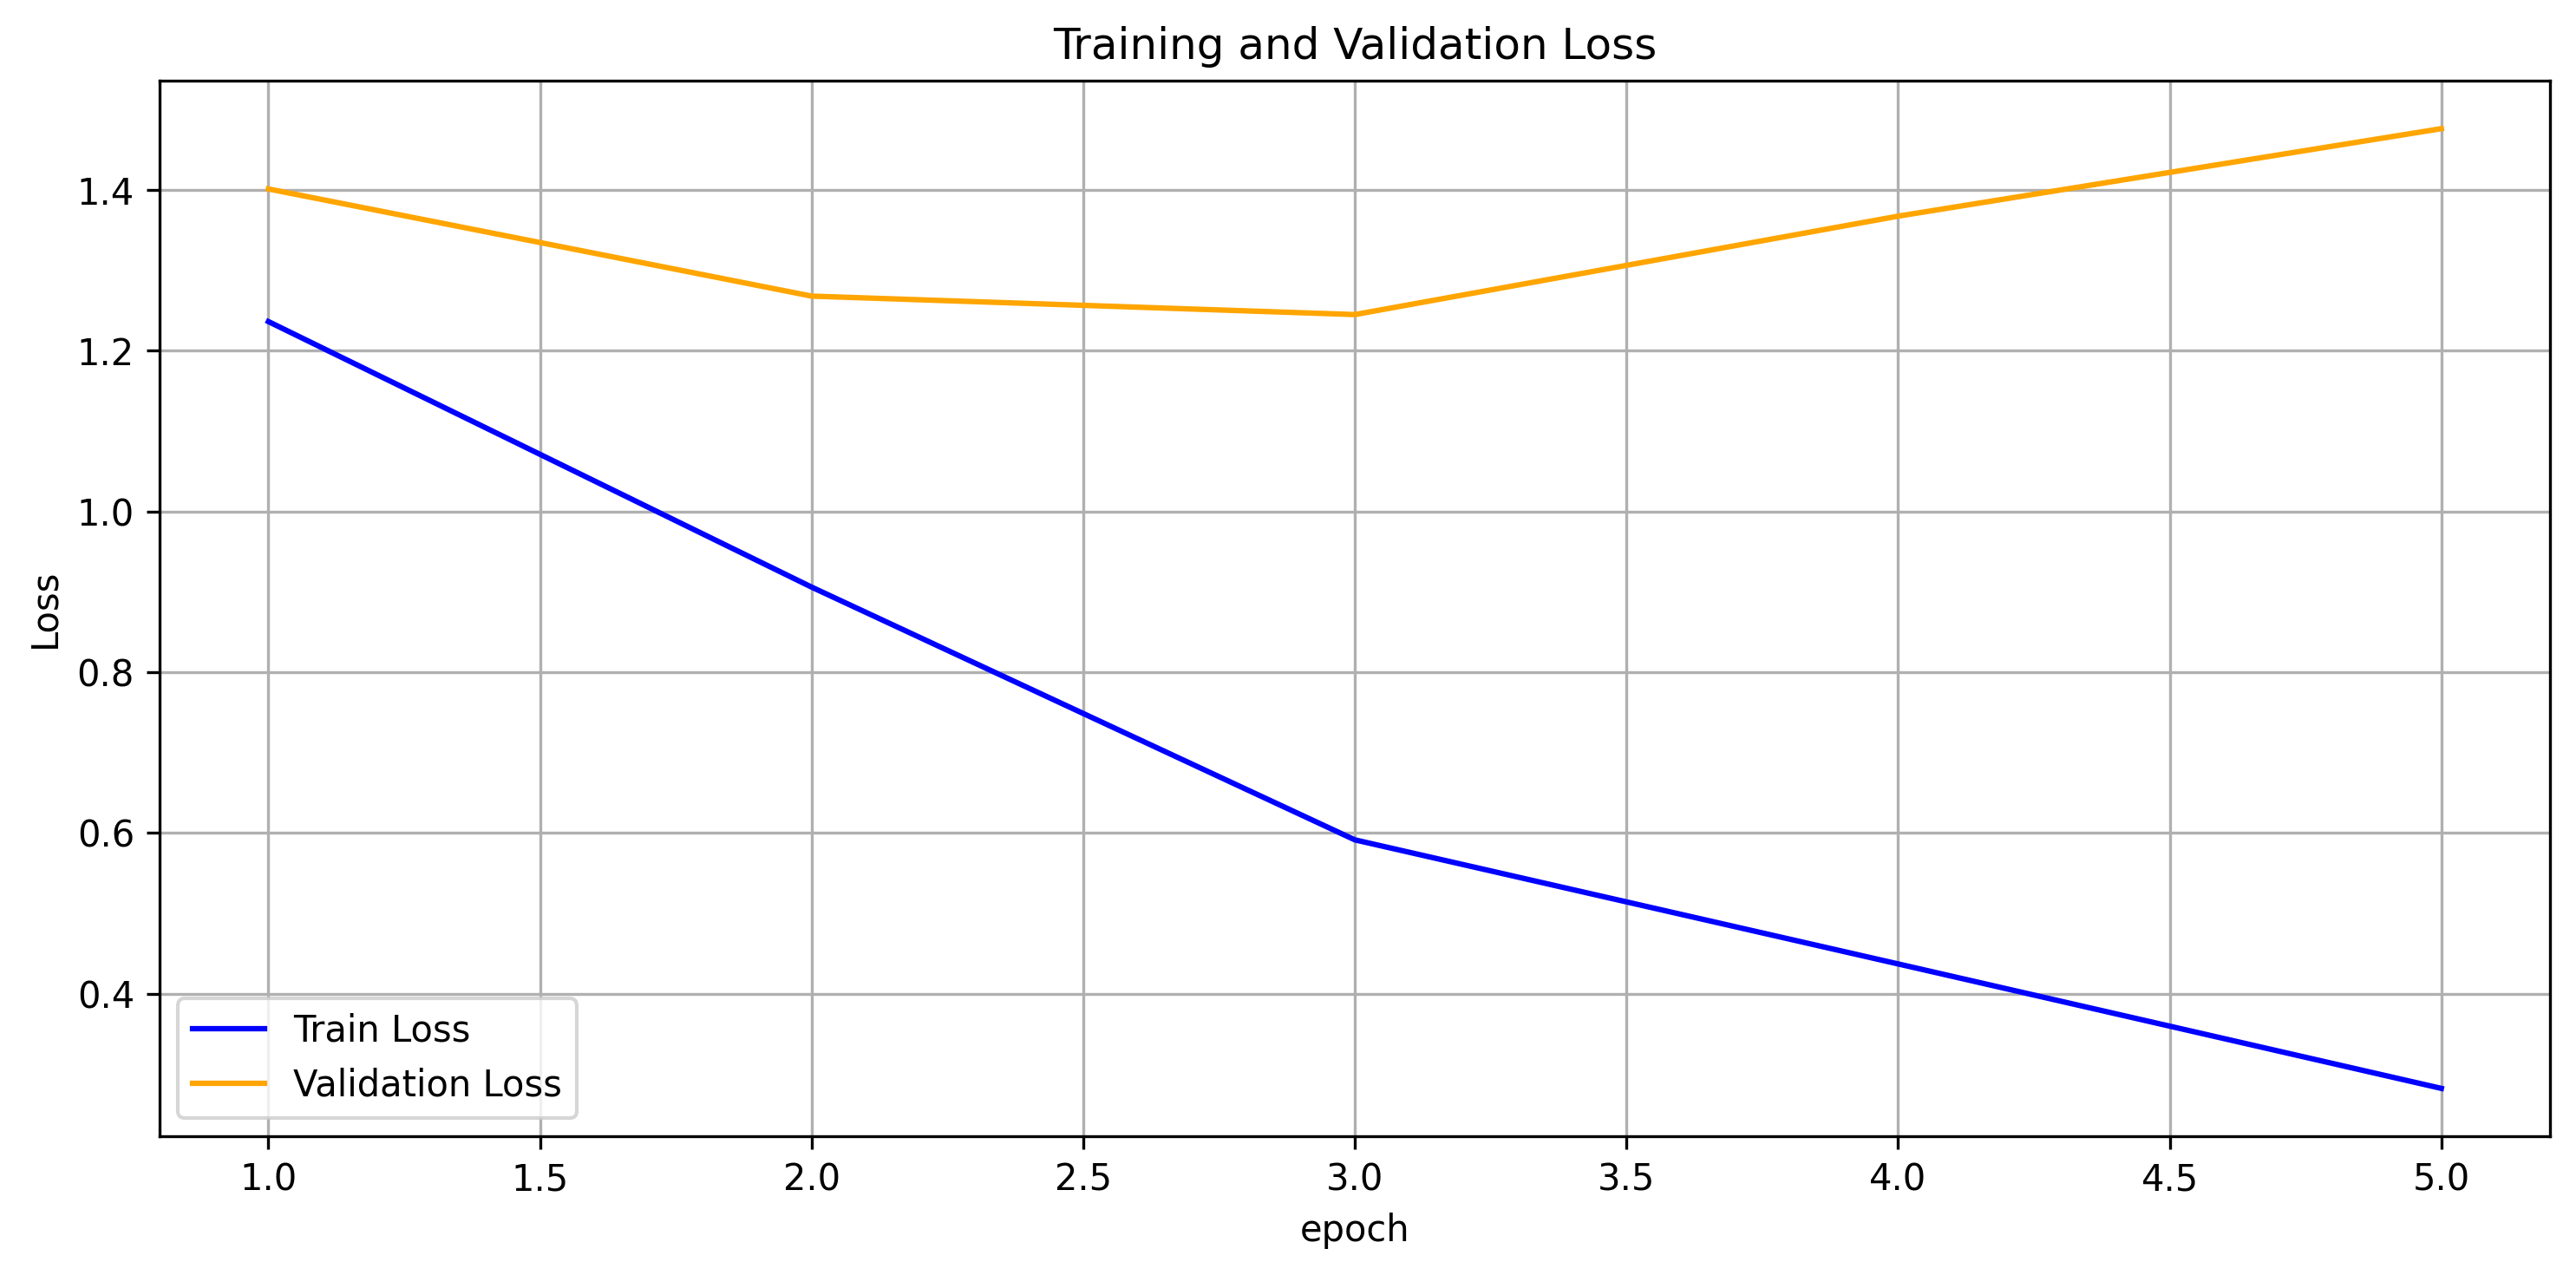

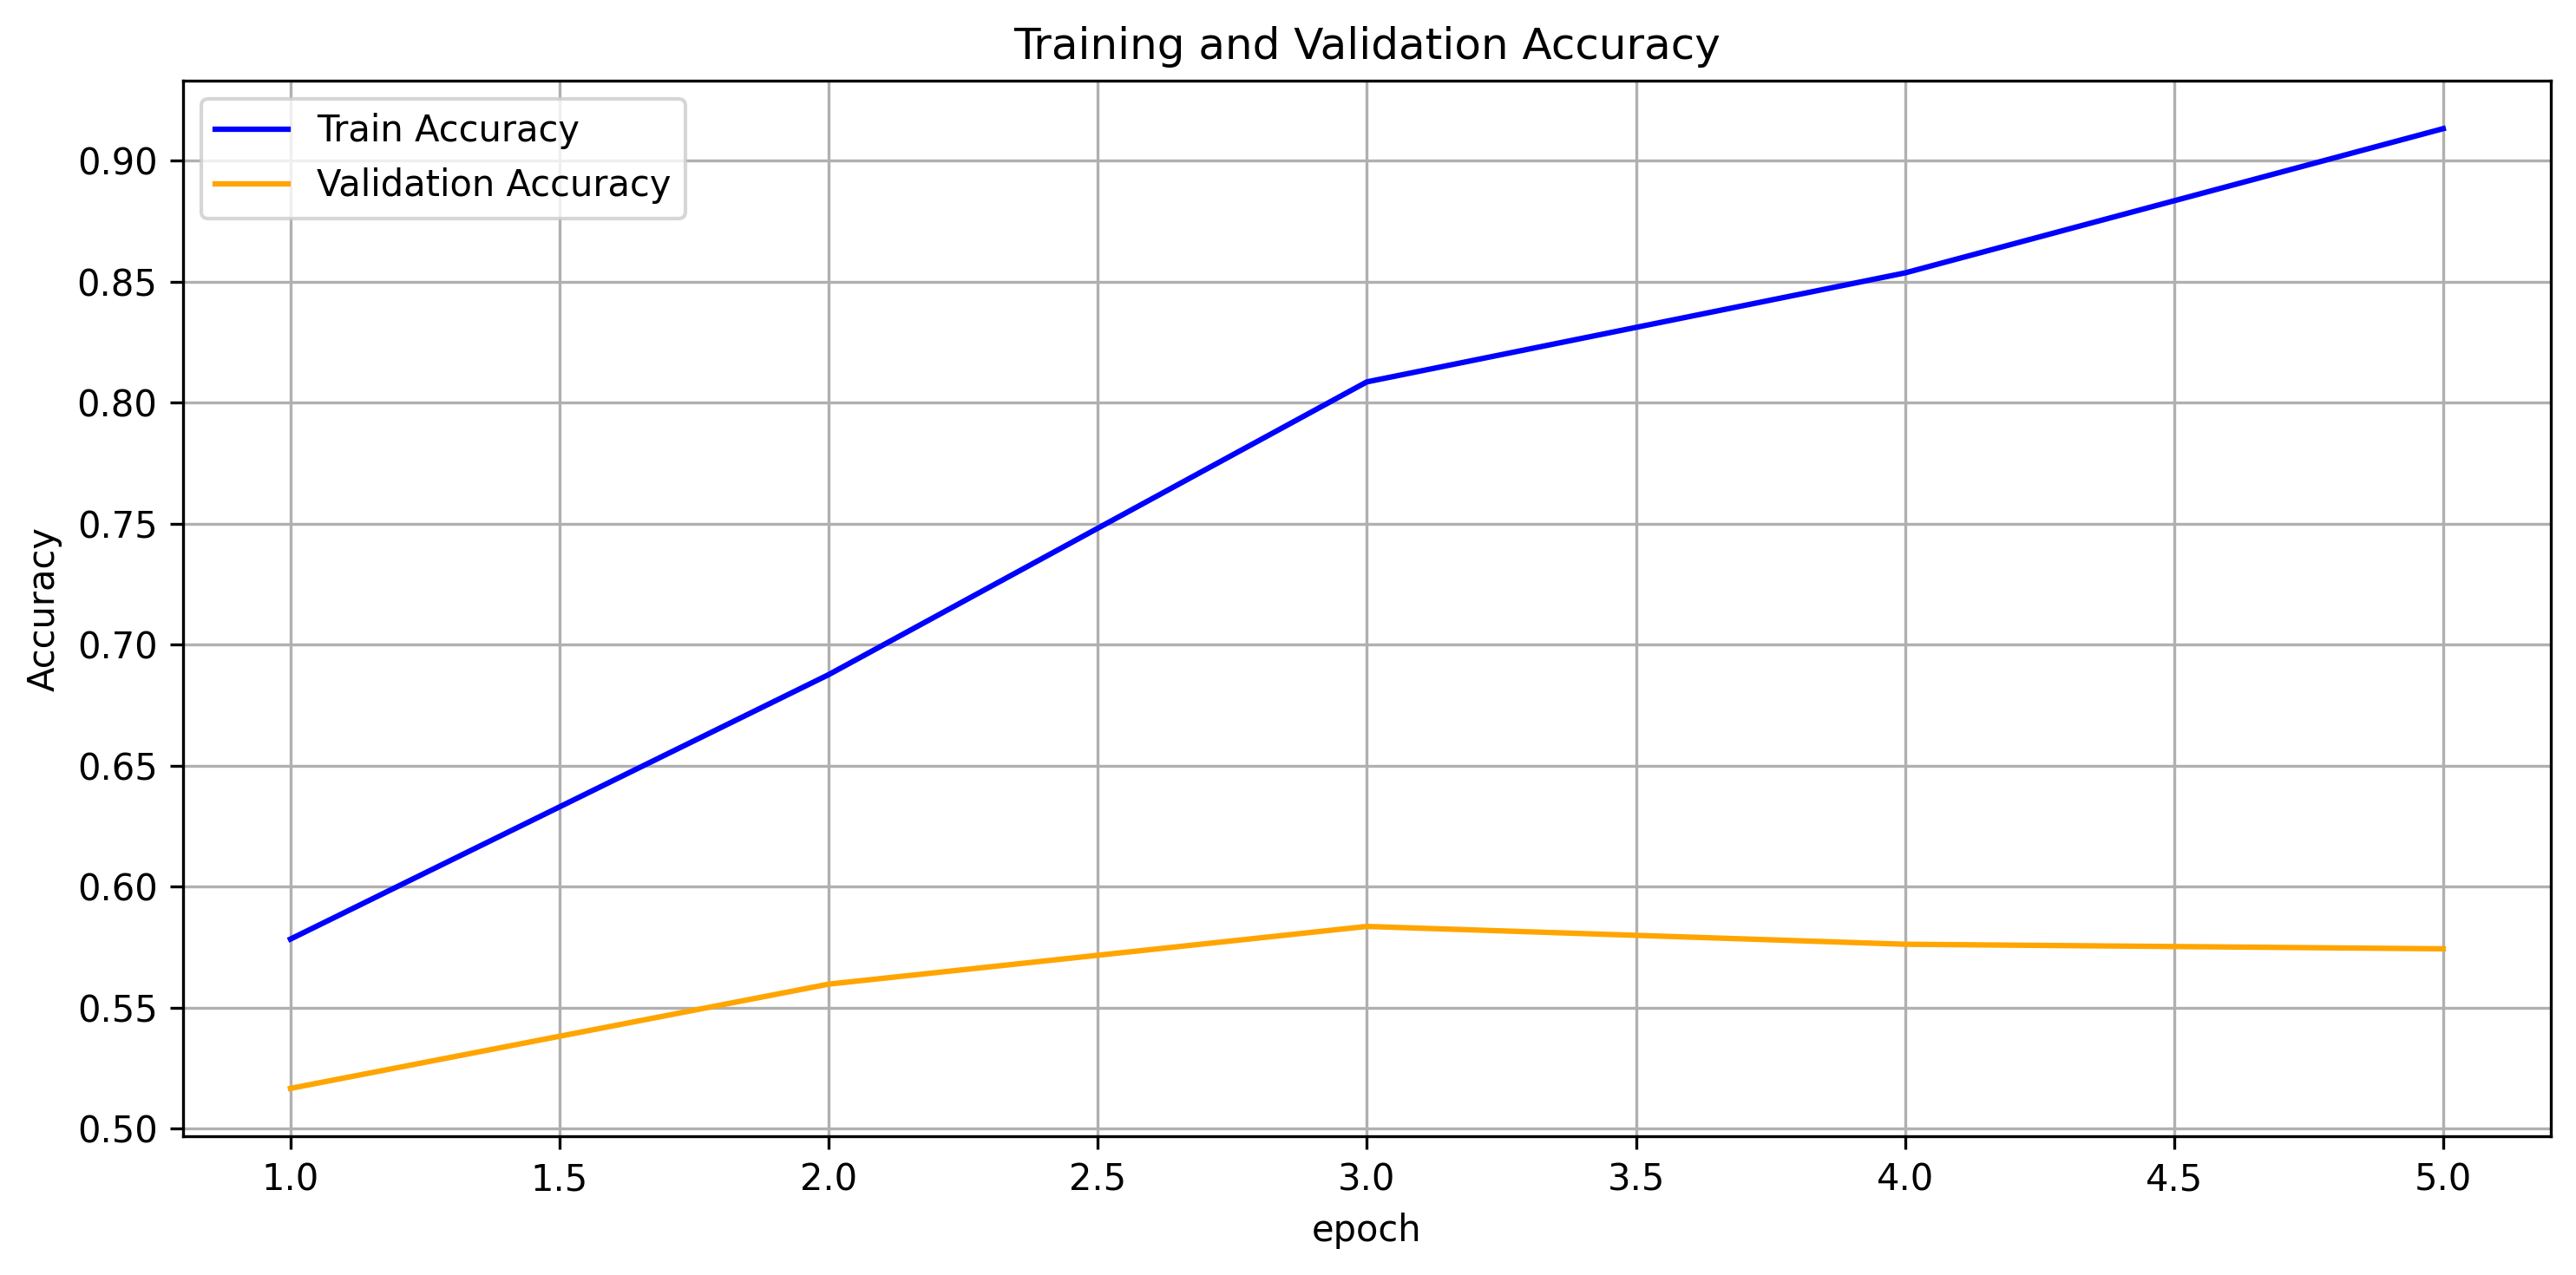

In [ ]:
plot_curves(curve['train loss'], curve['valid loss'], curve['train accuracy'], curve['valid accuracy'])